In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importing libraries**

In [ ]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re,json,nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score
stopwords_list ='stopwords-bn.txt'

In [ ]:

%%capture
!pip3 install bnbphoneticparser
# !pip3 install googletrans==4.0.0-rc1
!pip3 uninstall googletrans
!pip3 install googletrans==3.1.0a0
!pip3 install lingua-language-detector
!apt update
!apt install enchant --fix-missing

!pip3 install emoji
!pip install pyenchant
!apt-get install -y libenchant-2-2

In [ ]:

import googletrans
from bnbphoneticparser import BanglishToBengali
from bnbphoneticparser import BengaliToBanglish
import time
import string
import re
import enchant
from lingua import Language, LanguageDetectorBuilder
import emoji
import pandas as pd


In [ ]:
# coding=utf-8
translator = googletrans.Translator()
banglish2bengali = BanglishToBengali()
bengali2banglish = BengaliToBanglish()
d = enchant.Dict("en_US")
languages = [Language.ENGLISH, Language.BENGALI]
detector = LanguageDetectorBuilder.from_languages(*languages).build()
special_characters = "!\"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~।"

**Stored Dataset of fake and non-fake reviews**

In [ ]:
non_fake_data=pd.read_csv('/content/drive/MyDrive/1_data_ml/food review/merged-non-fake.csv')
print("Demo of Non-fake Dataset")
non_fake_data.sample(5)



Demo of Non-fake Dataset


,Translated,Label
722,অফার মাত্র ২০০ টাকায় থাই স্যুপ আর কম্বো প্লা...,1
409,গরুর মাংস খেতে খেতে অতীষ্ট হয়ে গেছিলাম । তাই ...,1
326,গত কিছু দিন আগে এক ভাইয়ের কাছ থেকে কয়েকটা টিশ...,1
899,আচার খেতে কম বেশি সবাই ভালোবাসে আমার এই পোস্...,1
318,খেয়ে আসলাম শ্যামলী স্কয়ারের বার্গার ঈণণ এর কি...,1


In [ ]:
print("Demo of Fake Dataset")
fake_data=pd.read_csv('/content/drive/MyDrive/1_data_ml/food review/merged_fake.csv')
fake_data.sample(5)

Demo of Fake Dataset


,Translated,Label
380,120 আইটেম এর বুফে ইফতার রাতের খাবার কেউ যদি আ...,0
94,কিনুন 1 পেতে 3 বিনামূল্যে কিনুন 1 মাংস বল পিজ...,0
715,ইতিবাচক পর্যালোচনা নাম তনু রান্নাঘর স্থান ণেও...,0
213,রিভিউ রাব্বানী হোটেল এন্ড রেস্টুরেন্ট রাব্বান...,0
301,সেরা অফার শ্যামলী বর্গক্ষেত্র আইটেম নাম মুরগী...,0


 **Information of Dataset**

In [ ]:
print("info of fake data")
fake_data.info()
print("info of non-fake data")
non_fake_data.info()


info of fake data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797 entries, 0 to 796
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Translated  797 non-null    object
 1   Label       797 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 12.6+ KB
info of non-fake data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 936 entries, 0 to 935
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Translated  936 non-null    object
 1   Label       936 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 14.8+ KB


**Creating a new dataset concating both non-fake and fake reviews dataset**

In [ ]:
data=pd.concat([fake_data,non_fake_data],ignore_index=True)

In [ ]:
data.rename(columns={'Translated':'review'},inplace=True)
data.rename(columns={'Label':'label'},inplace=True)

In [ ]:
data

,review,label
0,এমন সব পিজ্জা একটা কিনলে একটা ফ্রি ভাবা যায় ত...,0
1,ও চ চ ই আর বাইটসবার্গ চলছে ছাত্র দের জন্য রসা...,0
2,ও ভাই বার্গার তুমি এতো টেস্টি কেন আমার কি আর ...,0
3,ও মোহাব্বাত হি কেয়া যো তাকলিফ না দে জি ভাই ও ...,0
4,ও ললনা ও ললনা কাবাব দিলা পানি দিলা না কাবাব ল...,0
...,...,...
1728,অনেক রিভিউ দেখে গেলাম নিতে ক কামড় এ ১০০টাকা...,1
1729,অন্যরকম শান্তি লাগে পিজা বার্গে গেলে । বিশেষ...,1
1730,অফার অফার অফার চলছে ৯৯ টাকায় বার্গার ক্যাফে ...,1
1731,অফার কিনতে এক পেতে এক বিনামূল্যে আপনি যদি মহ...,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1733 entries, 0 to 1732
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  1733 non-null   object
 1   label   1733 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 27.2+ KB


**total columns and rows of data**

In [ ]:
data.shape

(1733, 2)

**Checking duplicate values**

In [ ]:
data.duplicated().sum()

0

**Creating a deep copy of main dataset**

In [ ]:
df = data.copy(deep=True)  # Independent copy

**Class distribution based on 'label'**

Missing values in each column:
 review    0
label     0
dtype: int64

Class distribution:
label
1    936
0    797
Name: count, dtype: int64


<ipython-input-18-077cb26adef5>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette=colors)


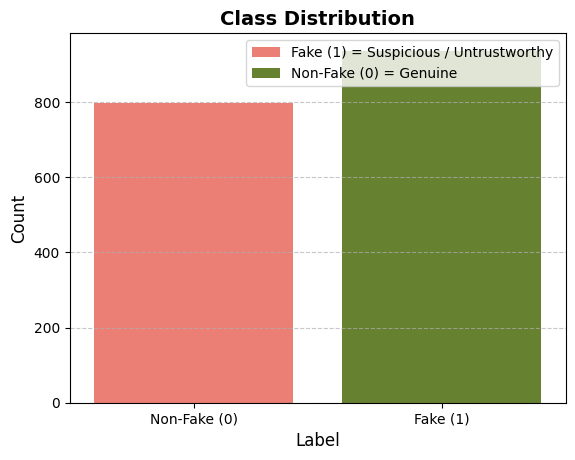

Fake Reviews (Label 1 - Fake):
797     আজ প্রথম বেলা বাইট শ্যামলী স্কয়ার এর ২৮০ টাকা...
798     আজ বনানী নরদান ইউনিভার্সিটিতে গেলাম আমার কাজি...
799     আজ বন্ধুকে নিয়ে গিয়েছিলাম বেইলি রোড এ । দ্যা ...
800     আজ বলবো পাস্তা কুঁড়েঘর সেট মেনু ৬ এর কথা স্ট...
801     আজ বসুন্ধরা সিটির দিল্লি দারবার এর বালতি বিরি...
Name: review, dtype: object

Non-Fake Reviews (Label 0 - Genuine):
0     এমন সব পিজ্জা একটা কিনলে একটা ফ্রি ভাবা যায় ত...
1     ও চ চ ই আর বাইটসবার্গ চলছে ছাত্র দের জন্য রসা...
2     ও ভাই বার্গার তুমি এতো টেস্টি কেন আমার কি আর ...
3     ও মোহাব্বাত হি কেয়া যো তাকলিফ না দে জি ভাই ও ...
4     ও ললনা ও ললনা কাবাব দিলা পানি দিলা না কাবাব ল...
Name: review, dtype: object


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


print("Missing values in each column:\n", df.isnull().sum())
print("\nClass distribution:")
print(df['label'].value_counts())


colors = ['#FF6F61', '#6B8E23']
sns.countplot(x='label', data=df, palette=colors)
plt.title('Class Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Non-Fake (0)', 'Fake (1)'])  # Custom Labels
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.legend(['Fake (1) = Suspicious / Untrustworthy', 'Non-Fake (0) = Genuine'], loc='upper right', fontsize=10)
plt.show()


print("\033[91mFake Reviews (Label 1 - Fake):\033[0m")
print(df[df['label'] == 1]['review'].head())
print("\n\033[92mNon-Fake Reviews (Label 0 - Genuine):\033[0m")
print(df[df['label'] == 0]['review'].head())


**Length distribution of dataset**

In [ ]:
df['review_length'] = df['review'].apply(len)


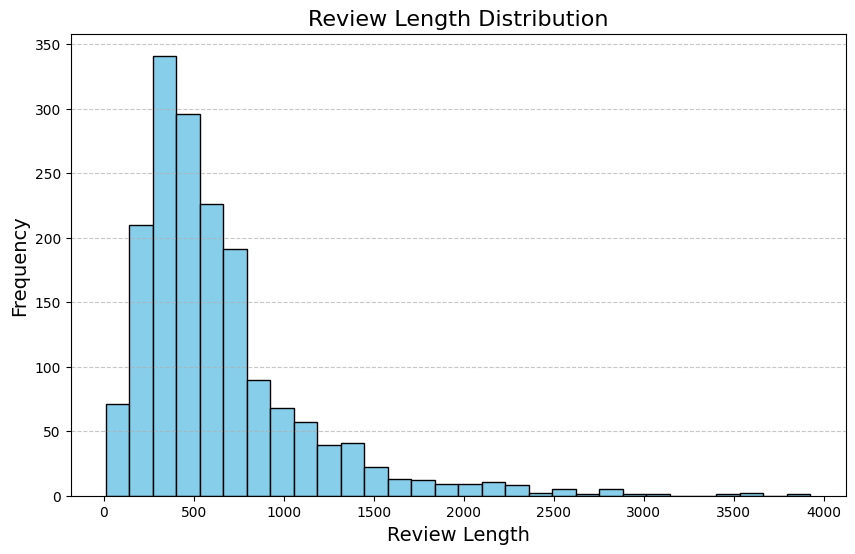

Maximum Length of a review: 3926
Minimum Length of a review: 11
Average Length of a reviews: 633.0


In [ ]:
import matplotlib.pyplot as plt

# Plot histogram of review lengths
plt.figure(figsize=(10, 6))
plt.hist(df['review_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Review Length Distribution', fontsize=16)
plt.xlabel('Review Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f"Maximum Length of a review: {max(df.review_length)}")
print(f"Minimum Length of a review: {min(df.review_length)}")
print(f"Average Length of a reviews: {round(np.mean(df.review_length),0)}")

**Example of sample feature extraction of words using TF-IDF**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorizer with Unigrams, Bigrams, and Trigrams
vectorizer = TfidfVectorizer(ngram_range=(1, 3))  # Includes Unigrams, Bigrams, and Trigrams
X_tfidf = vectorizer.fit_transform(df['review'])


print(f"Vocabulary size: {len(vectorizer.get_feature_names_out())}")
print("\nSample feature words:", vectorizer.get_feature_names_out()[:20])


Vocabulary size: 144742

Sample feature words: ['00' '00 04' '00 04 00' '00 10' '00 10 00' '00 am' '00 am 00' '00 pm'
 '00 pm এর' '00 অবস' '00 অবস তর' '00 আইট' '00 আইট 65' '00 আইট 75' '00 আম'
 '00 আম 00' '00 ইগস' '00 ইগস সব' '00 ইন' '00 ইন এখন']


**Example of Label Encoding and Splitting**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


def calc_ngram_tfidf(text_data):
    vectorizer = TfidfVectorizer(ngram_range=(1, 3))  # Unigram, Bigram, Trigram
    feature_vector = vectorizer.fit_transform(text_data)
    return vectorizer, feature_vector

def label_encoding(labels):
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)
    return encoded_labels

def dataset_split(feature_space, sentiment, test_size=0.2, random_state=42):
    return train_test_split(feature_space, sentiment, test_size=test_size, random_state=random_state)

cv, feature_vector = calc_ngram_tfidf(df['review'])
labels = label_encoding(df['label'])


X_train, X_test, y_train, y_test = dataset_split(feature_space=feature_vector, sentiment=labels)


print(f"Train feature shape: {X_train.shape}")
print(f"Test feature shape: {X_test.shape}")
print(f"Train labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")


Train feature shape: (1386, 144742)
Test feature shape: (347, 144742)
Train labels shape: (1386,)
Test labels shape: (347,)


# Model Development
**Used models are:**


*   Decision Tree
*   LogisticRegression
*RandomForest
*GradientBoosting
*AdaBoost
*XGBoost
*KNN
*LinearSVM
*RBF_SVM
*SGD




**Unigram Tf-idf Feature Extraction, Label Encoding, Splitting and hightlighting the models performance using confusion matrix**

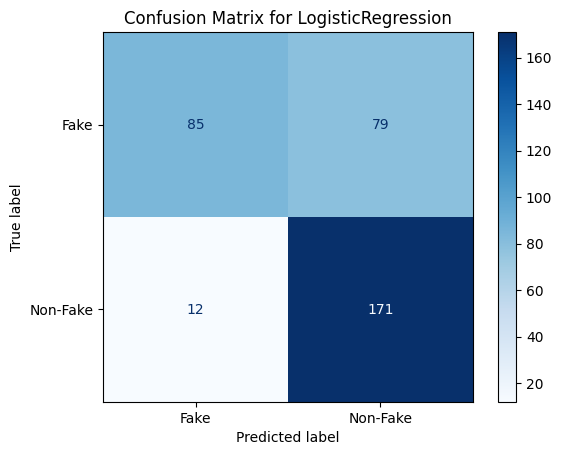

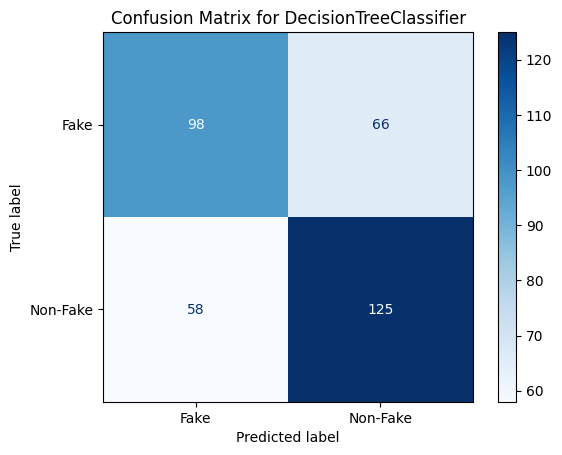

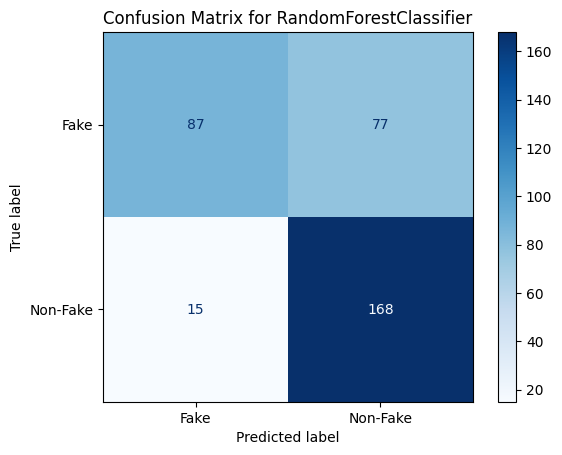

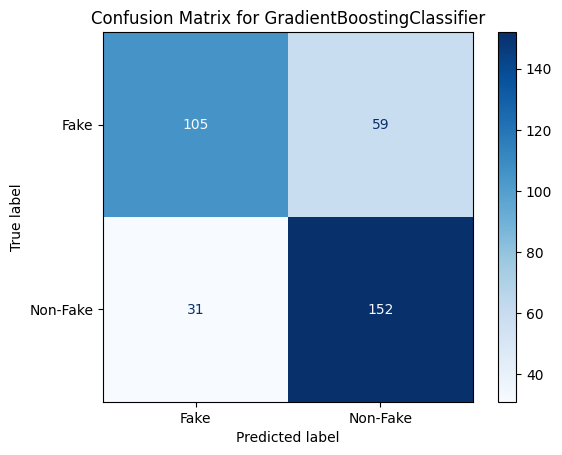

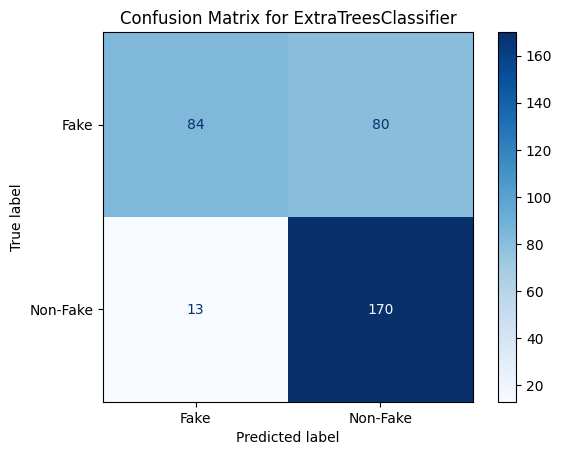

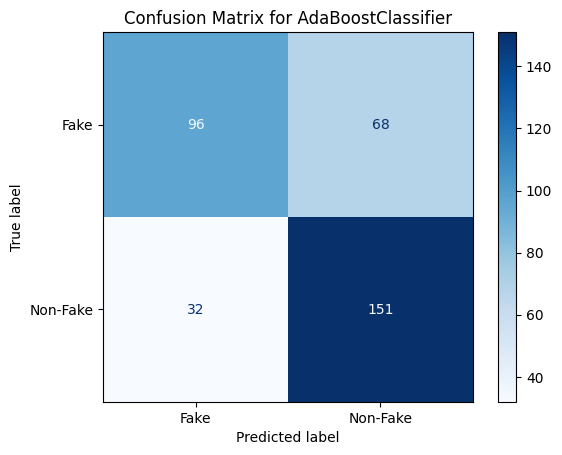

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:20:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


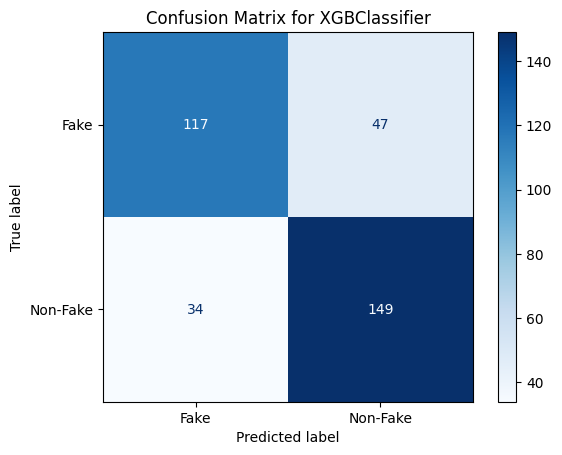

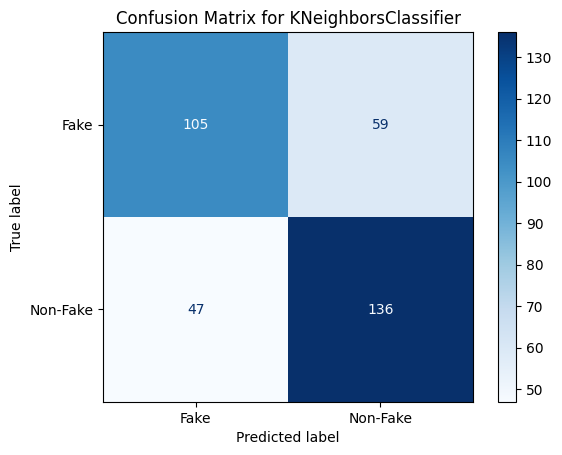

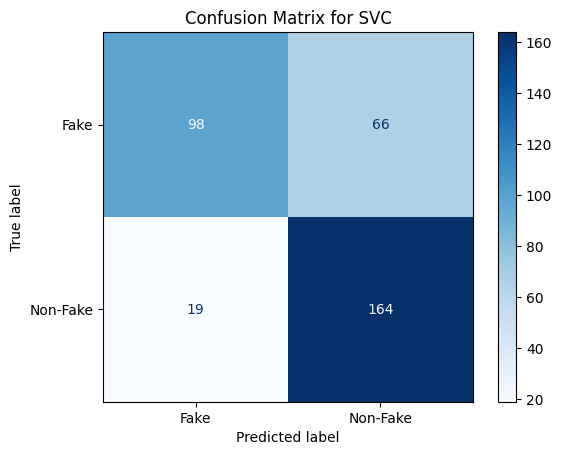

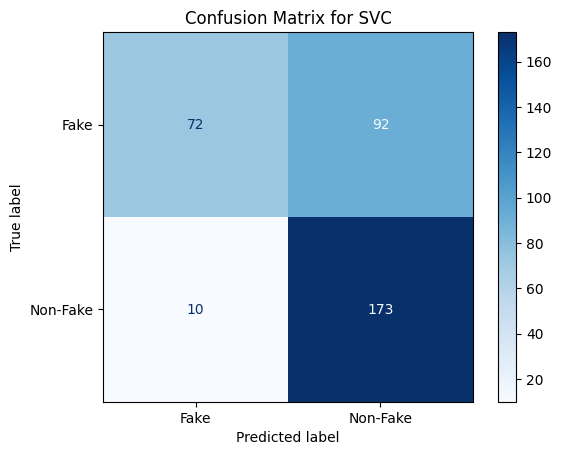

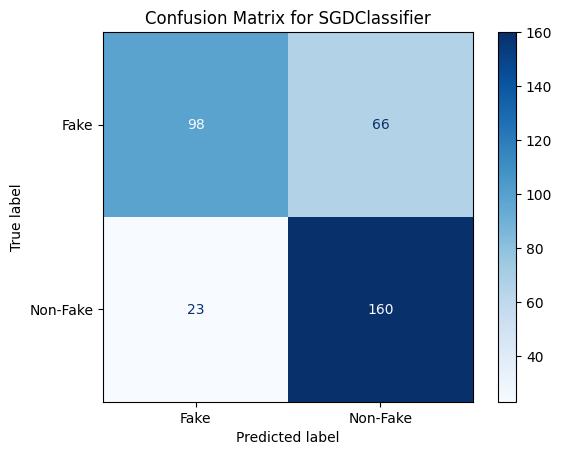

                    Accuracy  Precision    Recall  F1 Score
LogisticRegression  0.737752   0.684000  0.934426  0.789838
DecisionTree        0.642651   0.654450  0.683060  0.668449
RandomForest        0.734870   0.685714  0.918033  0.785047
GradientBoosting    0.740634   0.720379  0.830601  0.771574
ExtraTrees          0.731988   0.680000  0.928962  0.785219
AdaBoost            0.711816   0.689498  0.825137  0.751244
XGBoost             0.766571   0.760204  0.814208  0.786280
KNN                 0.694524   0.697436  0.743169  0.719577
LinearSVM           0.755043   0.713043  0.896175  0.794189
RBF_SVM             0.706052   0.652830  0.945355  0.772321
SGD                 0.743516   0.707965  0.874317  0.782396


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def ml_models_for_unigram_tfidf():
    # Define models
    ml_models = [
        LogisticRegression(max_iter=1000),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        GradientBoostingClassifier(),
        ExtraTreesClassifier(),
        AdaBoostClassifier(),
        XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        KNeighborsClassifier(),
        SVC(kernel='linear'),
        SVC(kernel='rbf'),
        SGDClassifier()
    ]

    # Define model names
    model_names = [
      'LogisticRegression',
        'DecisionTree',
        'RandomForest',
        'GradientBoosting',
        'ExtraTrees',
        'AdaBoost',
        'XGBoost',
        'KNN',
        'LinearSVM',
        'RBF_SVM',
        'SGD'
    ]

    return ml_models, model_names

def model_performance_with_confusion_matrix(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')  # Assuming binary classification
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Visualize the confusion matrix
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Non-Fake"])
    cm_display.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {model.__class__.__name__}')
    plt.show()

    # Return all metrics
    return accuracy, precision, recall, f1, cm

# Function to evaluate models and display confusion matrix
def evaluate_models_with_cm(X_train, X_test, y_train, y_test):
    # Get models and names
    ml_models, model_names = ml_models_for_unigram_tfidf()

    # Dictionary to store performance metrics
    performance = {}

    # Evaluate each model and save its performance
    for i, model in enumerate(ml_models):
        accuracy, precision, recall, f1, cm = model_performance_with_confusion_matrix(model, X_train, X_test, y_train, y_test)

        # Save the metrics for each model
        performance[model_names[i]] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1
        }

    # Convert the performance dictionary to a pandas DataFrame for better visualization
    performance_df = pd.DataFrame(performance).T
    return performance_df

# Example usage:
# Assuming X_train, X_test, y_train, y_test are defined from the previous code
performance_df = evaluate_models_with_cm(X_train, X_test, y_train, y_test)
print(performance_df)


**using Unigram,bigram and trigram TF-idf,storing the best model using joblib and pickle**

Evaluating Models for Unigram TF-IDF...


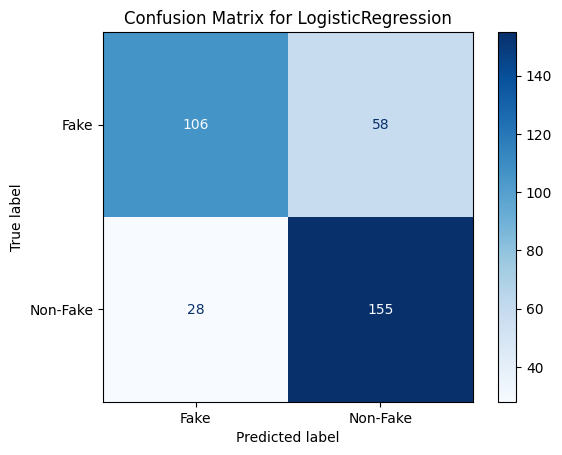

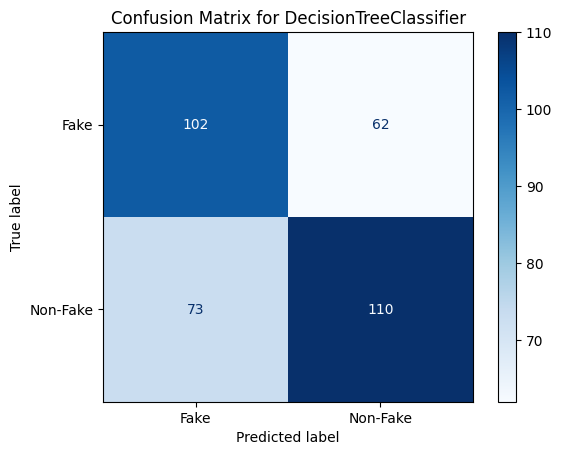

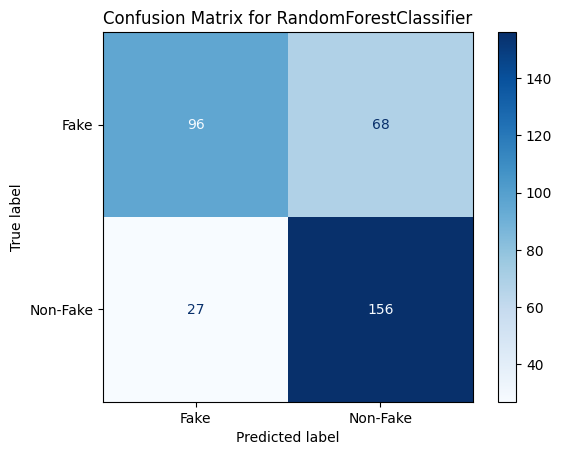

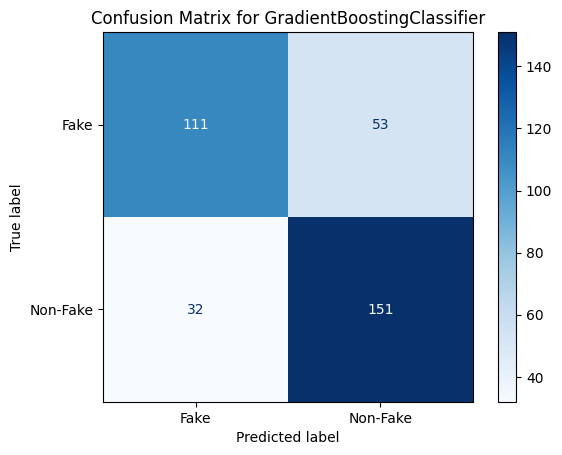

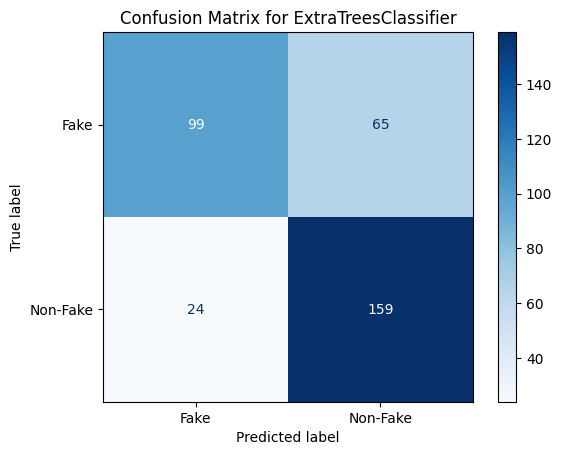

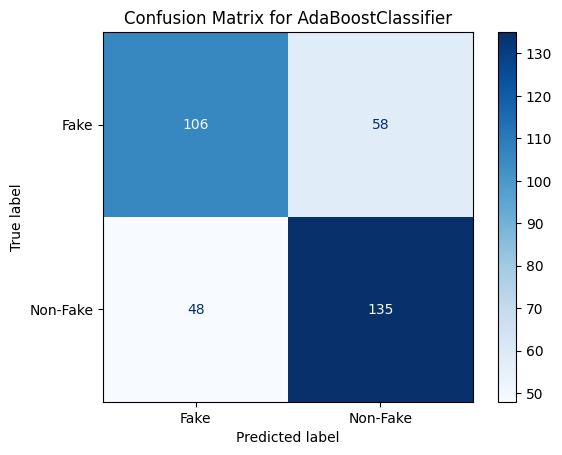

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:10:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


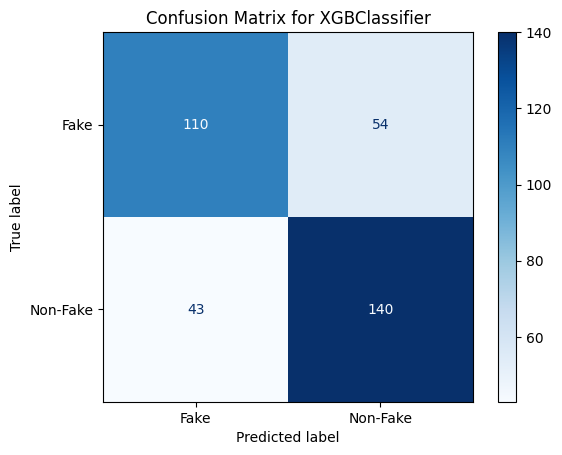

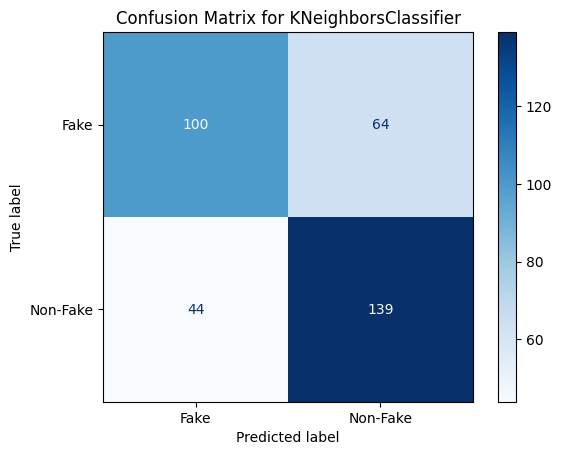

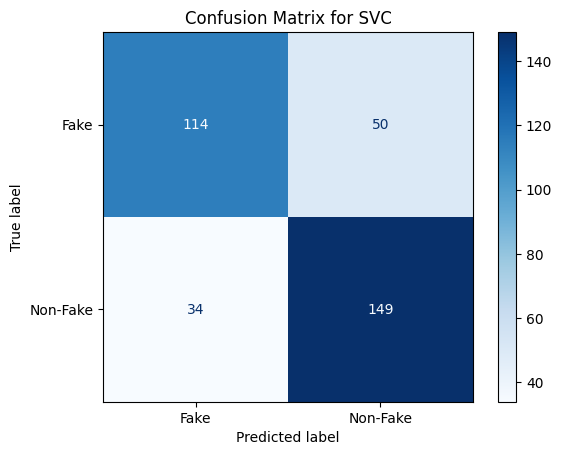

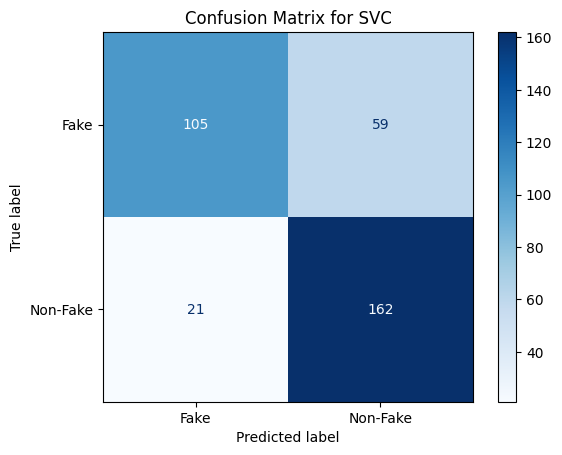

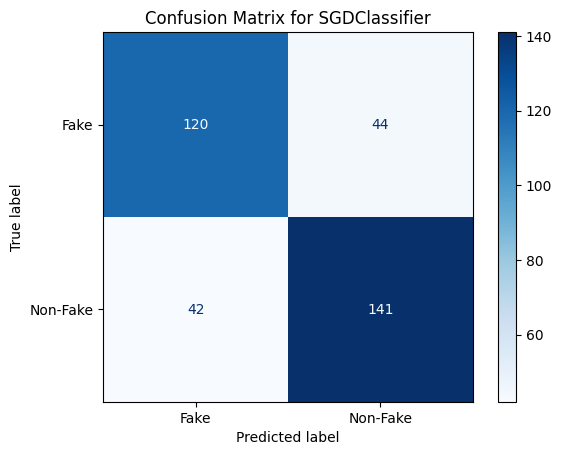

Evaluating Models for Bigram TF-IDF...


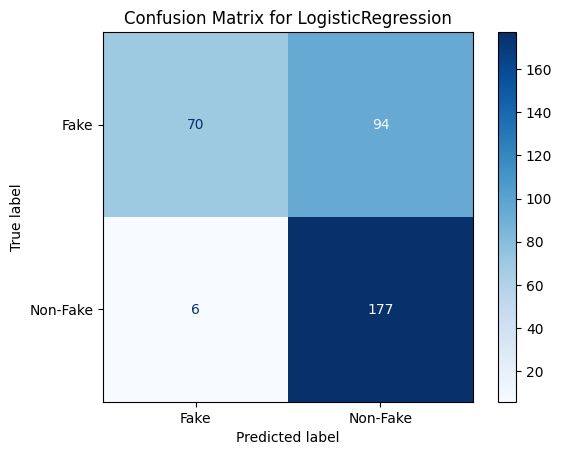

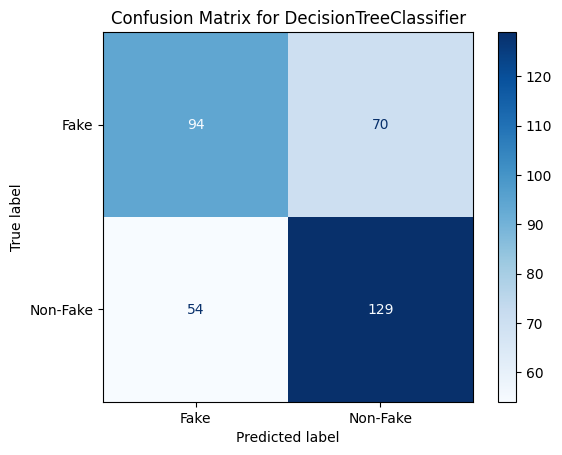

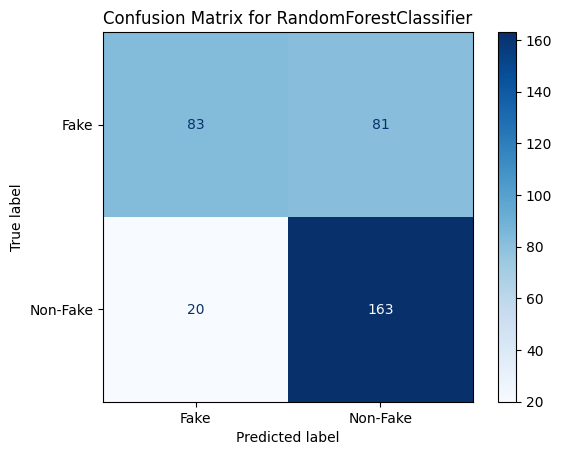

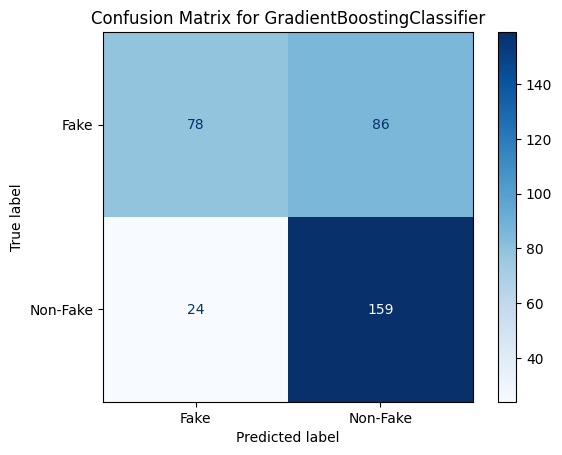

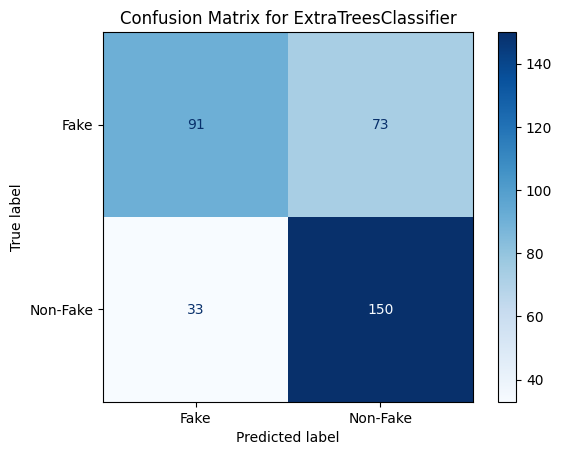

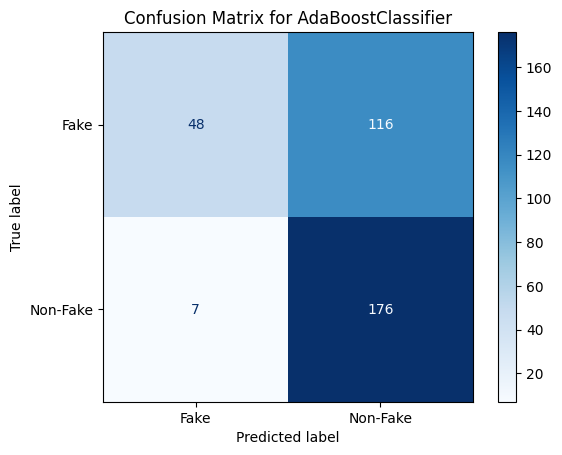

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:10:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


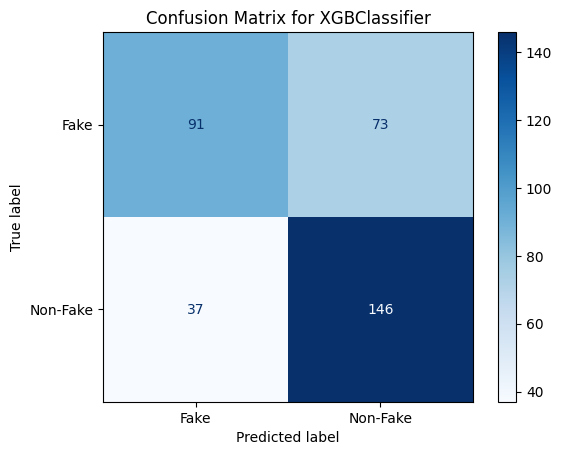

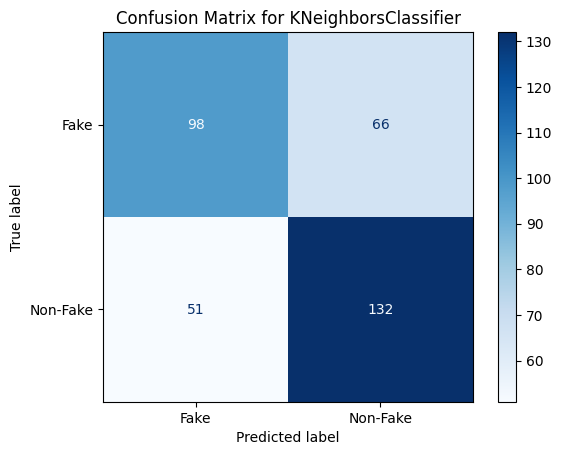

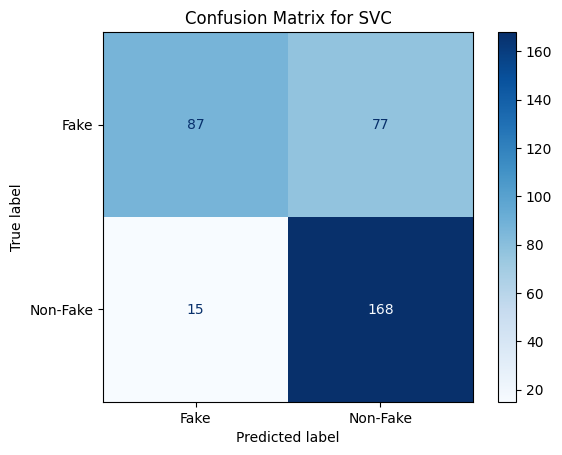

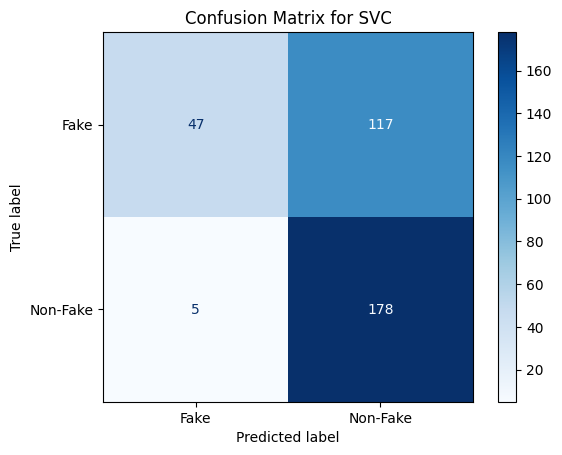

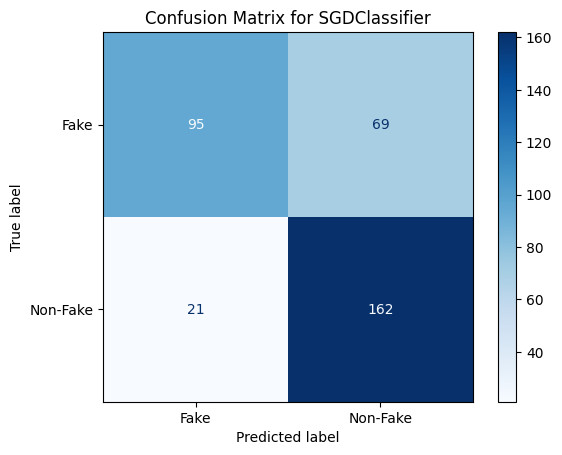

Evaluating Models for Trigram TF-IDF...


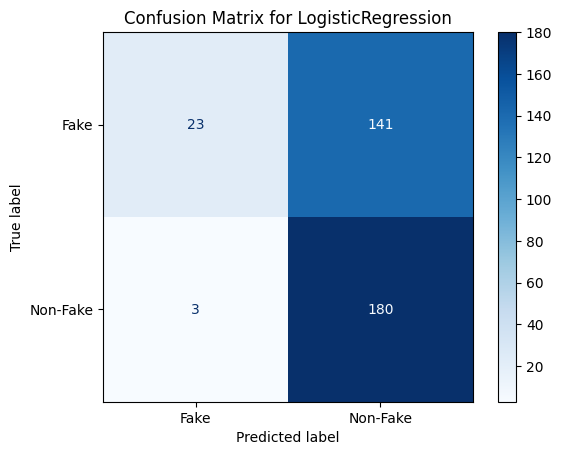

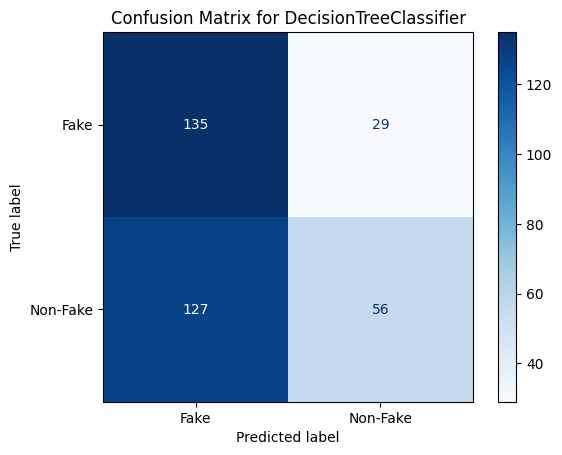

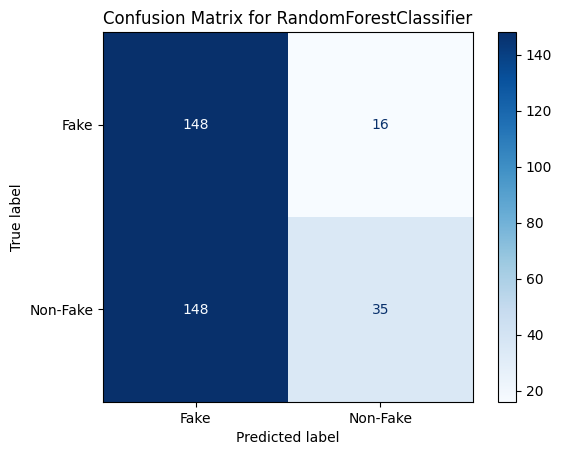

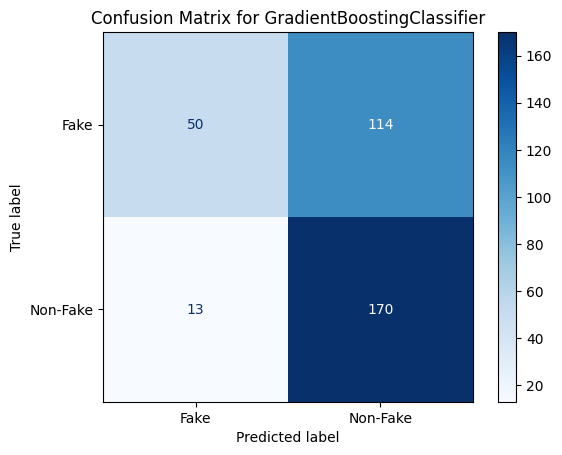

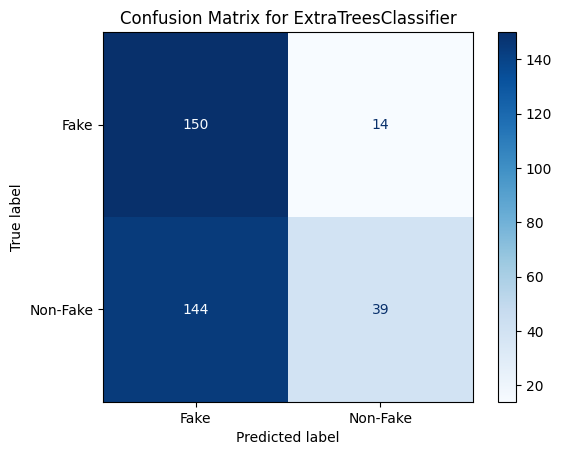

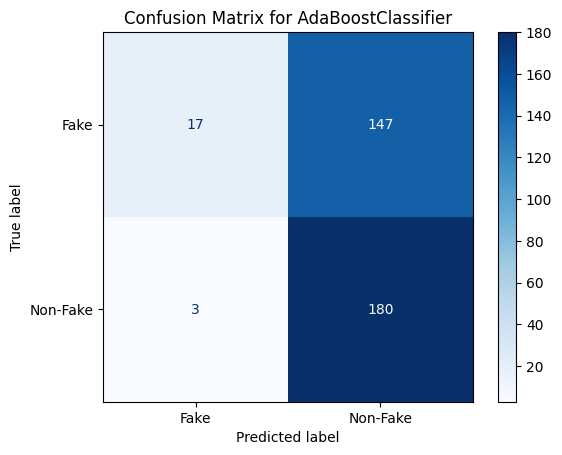

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:11:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


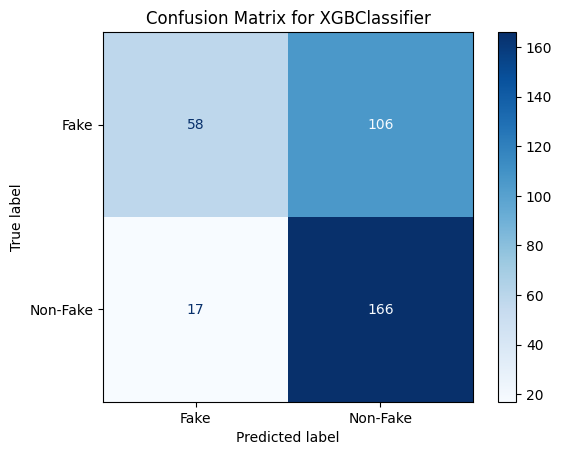

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


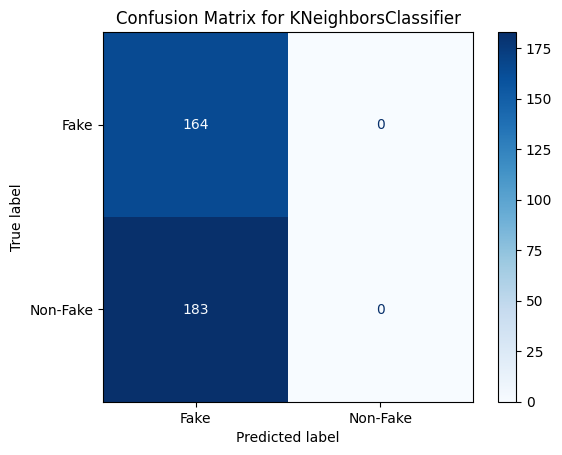

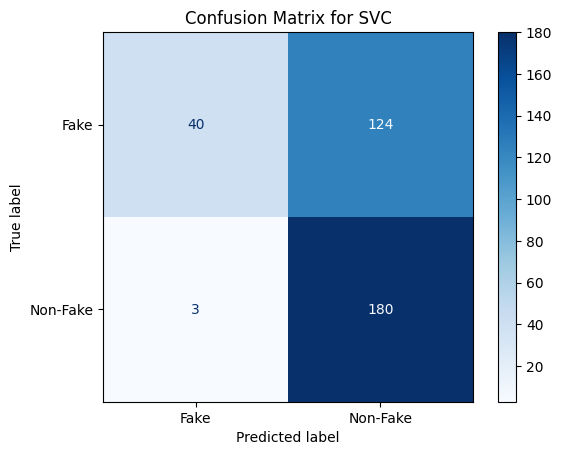

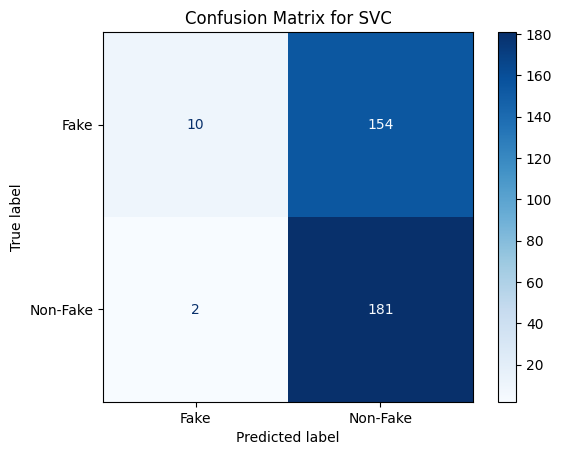

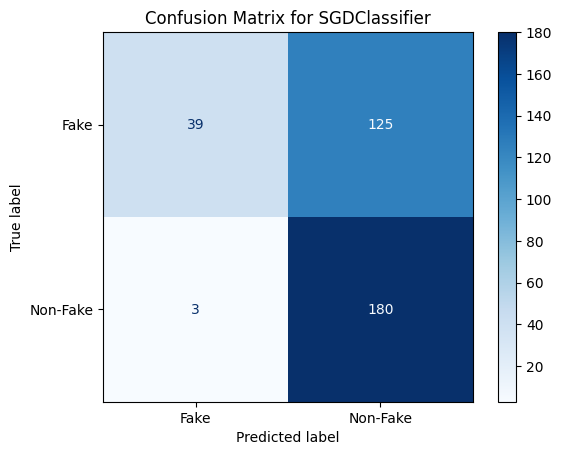

Unigram Performance:
                    Accuracy  Precision    Recall  F1 Score
LogisticRegression  0.752161   0.727700  0.846995  0.782828
DecisionTree        0.610951   0.639535  0.601093  0.619718
RandomForest        0.726225   0.696429  0.852459  0.766585
GradientBoosting    0.755043   0.740196  0.825137  0.780362
ExtraTrees          0.743516   0.709821  0.868852  0.781327
AdaBoost            0.694524   0.699482  0.737705  0.718085
XGBoost             0.720461   0.721649  0.765027  0.742706
KNN                 0.688761   0.684729  0.759563  0.720207
LinearSVM           0.757925   0.748744  0.814208  0.780105
RBF_SVM             0.769452   0.733032  0.885246  0.801980
SGD                 0.752161   0.762162  0.770492  0.766304
Bigram Performance:
                    Accuracy  Precision    Recall  F1 Score
LogisticRegression  0.711816   0.653137  0.967213  0.779736
DecisionTree        0.642651   0.648241  0.704918  0.675393
RandomForest        0.708934   0.668033  0.890710  0.763466

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import joblib

def calc_ngram_tfidf(text_data, ngram_range):
    vectorizer = TfidfVectorizer(ngram_range=ngram_range)  # N-gram range
    feature_vector = vectorizer.fit_transform(text_data)
    return vectorizer, feature_vector

def label_encoding(labels):
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)
    return encoded_labels

def dataset_split(feature_space, sentiment, test_size=0.2, random_state=42):
    return train_test_split(feature_space, sentiment, test_size=test_size, random_state=random_state)


def ml_models_for_unigram_tfidf():
    ml_models = [
        LogisticRegression(max_iter=400),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        GradientBoostingClassifier(),
        ExtraTreesClassifier(),
        AdaBoostClassifier(),
        XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        KNeighborsClassifier(),
        SVC(kernel='linear'),
        SVC(kernel='rbf'),
        SGDClassifier()
    ]

    # Define model names
    model_names = [
      'LogisticRegression',
      'DecisionTree',
      'RandomForest',
      'GradientBoosting',
      'ExtraTrees',
      'AdaBoost',
      'XGBoost',
      'KNN',
      'LinearSVM',
      'RBF_SVM',
      'SGD'
    ]

    return ml_models, model_names

def model_performance_with_confusion_matrix(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')  # Assuming binary classification
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')


    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Non-Fake"])
    cm_display.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {model.__class__.__name__}')
    plt.show()

    return accuracy, precision, recall, f1, cm

def evaluate_models_for_ngram(X_train, X_test, y_train, y_test, ngram_type="Unigram"):
    print(f"Evaluating Models for {ngram_type} TF-IDF...")
    ml_models, model_names = ml_models_for_unigram_tfidf()


    performance = {}

    for i, model in enumerate(ml_models):
        accuracy, precision, recall, f1, cm = model_performance_with_confusion_matrix(model, X_train, X_test, y_train, y_test)

        # Save the metrics for each model
        performance[model_names[i]] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1
        }

    # Convert the performance dictionary to a pandas DataFrame for better visualization
    performance_df = pd.DataFrame(performance).T
    return performance_df


# --- 1. Unigram TF-IDF ---
cv_uni, feature_vector_uni = calc_ngram_tfidf(df['review'], ngram_range=(1, 1))
labels_uni = label_encoding(df['label'])
X_train_uni, X_test_uni, y_train_uni, y_test_uni = dataset_split(feature_space=feature_vector_uni, sentiment=labels_uni)

# --- 2. Bigram TF-IDF ---
cv_bi, feature_vector_bi = calc_ngram_tfidf(df['review'], ngram_range=(2, 2))
labels_bi = label_encoding(df['label'])
X_train_bi, X_test_bi, y_train_bi, y_test_bi = dataset_split(feature_space=feature_vector_bi, sentiment=labels_bi)

# --- 3. Trigram TF-IDF ---
cv_tri, feature_vector_tri = calc_ngram_tfidf(df['review'], ngram_range=(3, 3))
labels_tri = label_encoding(df['label'])
X_train_tri, X_test_tri, y_train_tri, y_test_tri = dataset_split(feature_space=feature_vector_tri, sentiment=labels_tri)

# --- Model Evaluation ---
performance_uni = evaluate_models_for_ngram(X_train_uni, X_test_uni, y_train_uni, y_test_uni, ngram_type="Unigram")
performance_bi = evaluate_models_for_ngram(X_train_bi, X_test_bi, y_train_bi, y_test_bi, ngram_type="Bigram")
performance_tri = evaluate_models_for_ngram(X_train_tri, X_test_tri, y_train_tri, y_test_tri, ngram_type="Trigram")

# Print performance of each n-gram model
print("Unigram Performance:")
print(performance_uni)

print("Bigram Performance:")
print(performance_bi)

print("Trigram Performance:")
print(performance_tri)


best_ngram_type = None
best_performance = None

if performance_uni['Accuracy'].max() > performance_bi['Accuracy'].max() and performance_uni['Accuracy'].max() > performance_tri['Accuracy'].max():
    best_performance = performance_uni
    best_ngram_type = "Unigram"
    best_vectorizer = cv_uni
elif performance_bi['Accuracy'].max() > performance_uni['Accuracy'].max() and performance_bi['Accuracy'].max() > performance_tri['Accuracy'].max():
    best_performance = performance_bi
    best_ngram_type = "Bigram"
    best_vectorizer = cv_bi
else:
    best_performance = performance_tri
    best_ngram_type = "Trigram"
    best_vectorizer = cv_tri


best_model_name = best_performance['Accuracy'].idxmax()


ml_models, model_names = ml_models_for_unigram_tfidf()
best_model_index = model_names.index(best_model_name)
best_model = ml_models[best_model_index]


joblib.dump(best_model, "best_model.pkl")
joblib.dump(best_vectorizer, "best_vectorizer.pkl")

print(f"Best Model ({best_model_name}) saved as 'best_model.pkl'.")
print(f"Best {best_ngram_type} Vectorizer saved as 'best_vectorizer.pkl'.")
print(f"Is model fitted? {hasattr(best_model, 'feature_importances_')}")

Evaluating Models for Unigram TF-IDF...


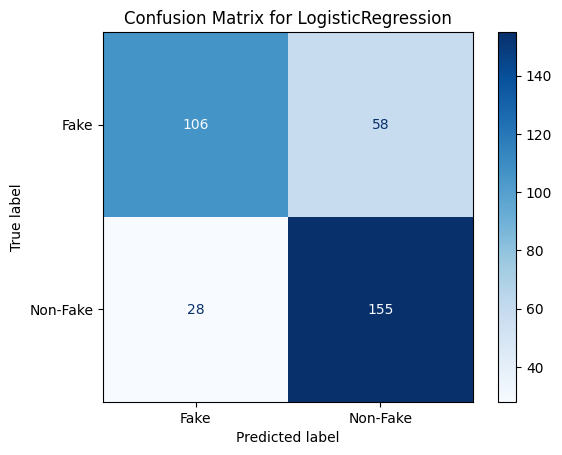

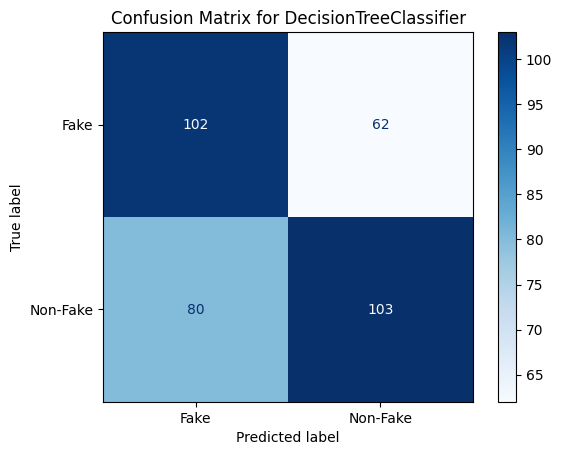

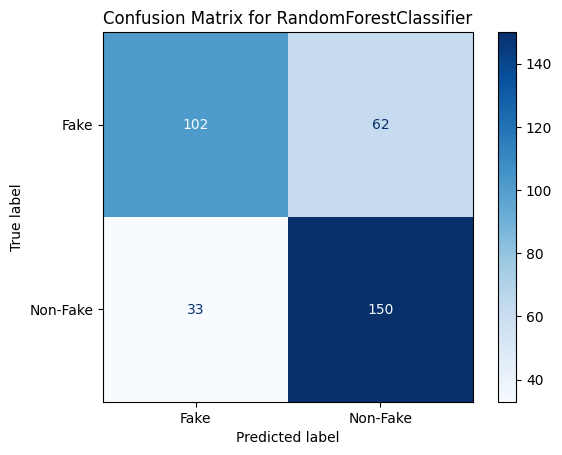

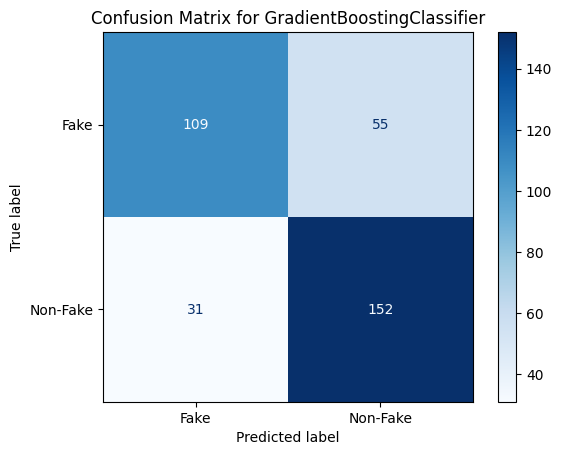

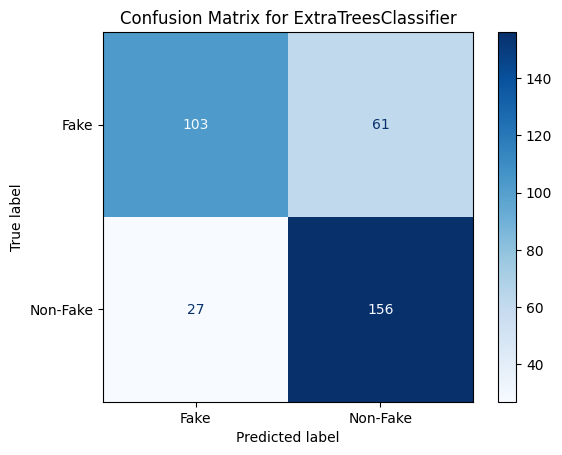

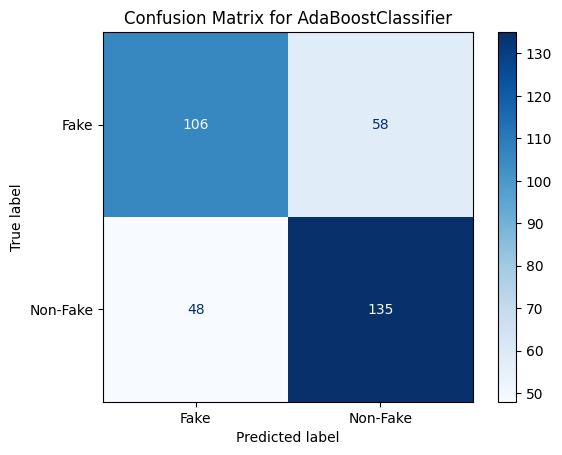

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:56:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


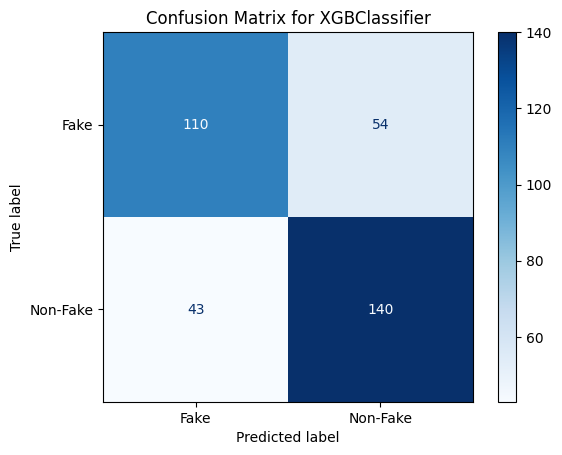

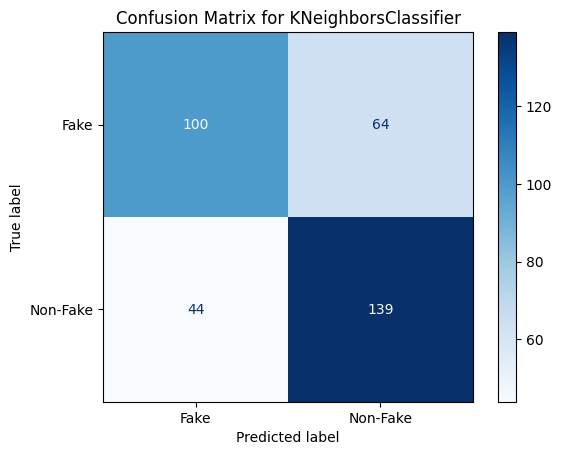

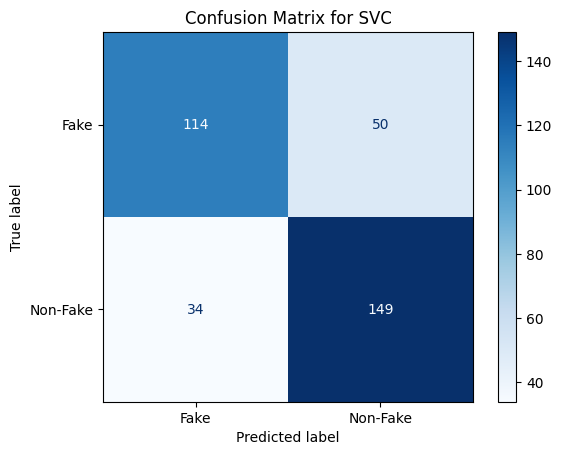

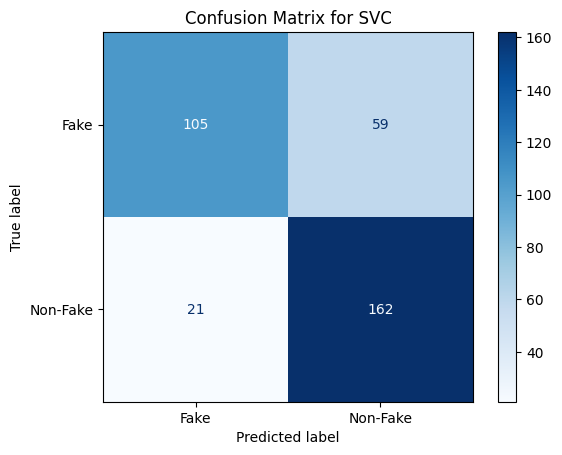

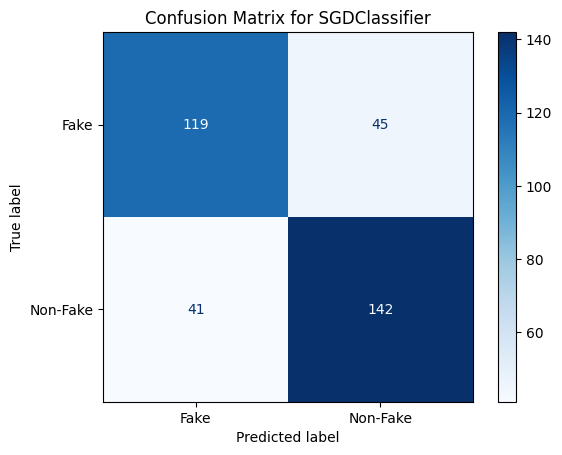

Evaluating Models for Bigram TF-IDF...


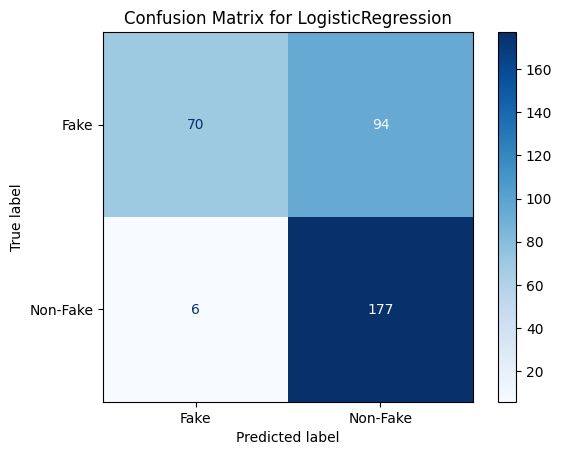

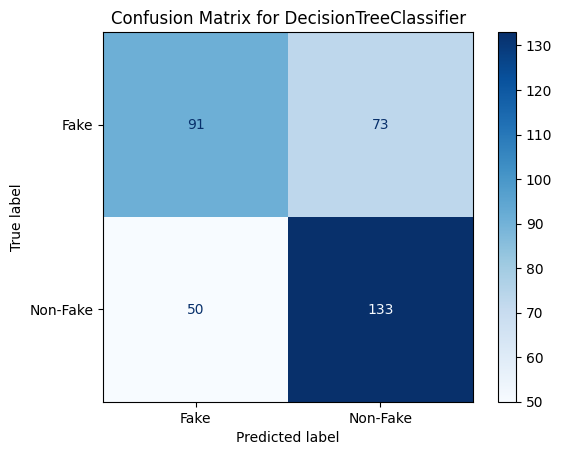

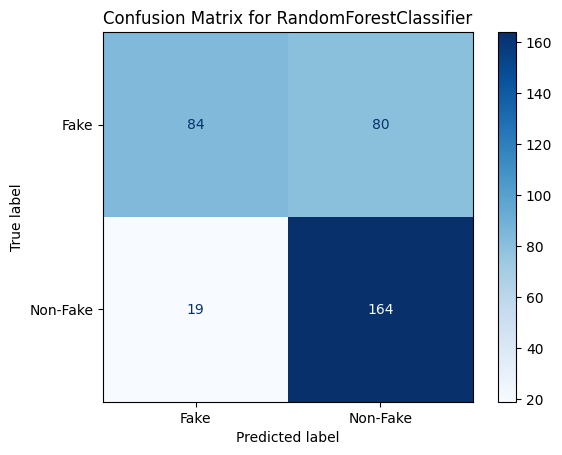

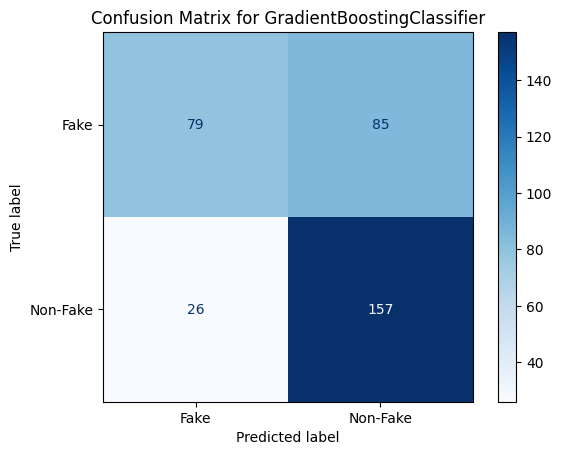

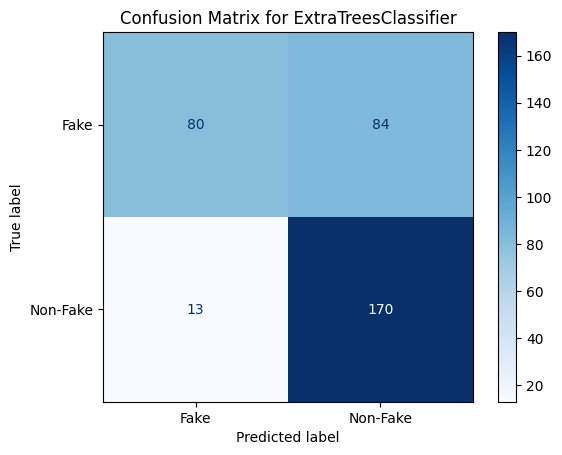

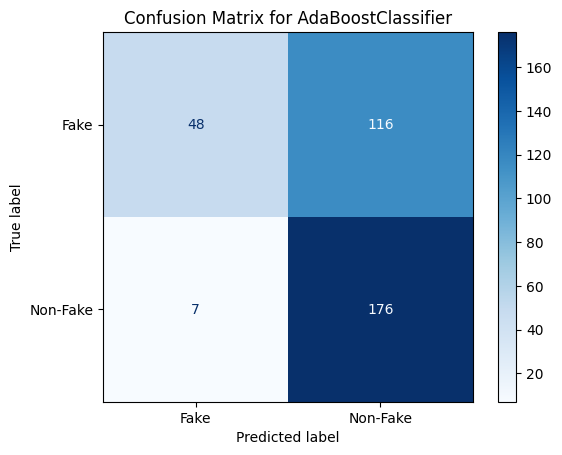

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:57:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


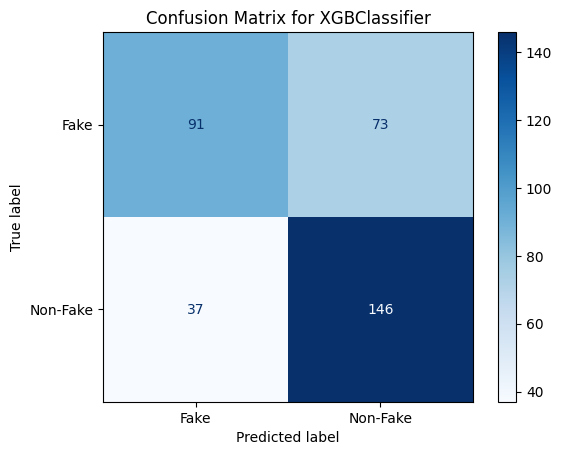

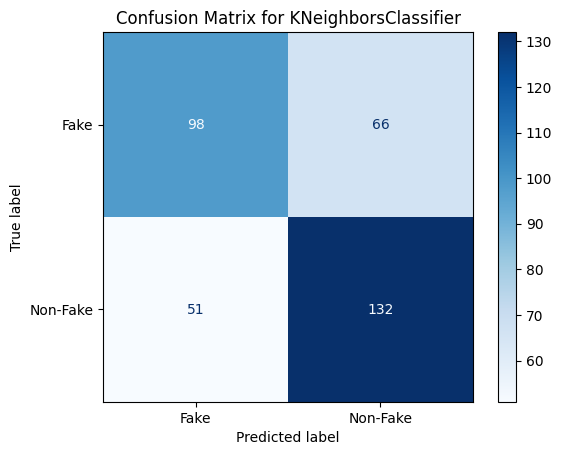

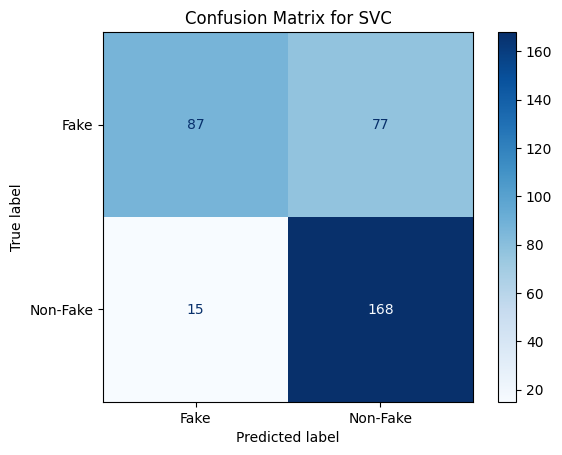

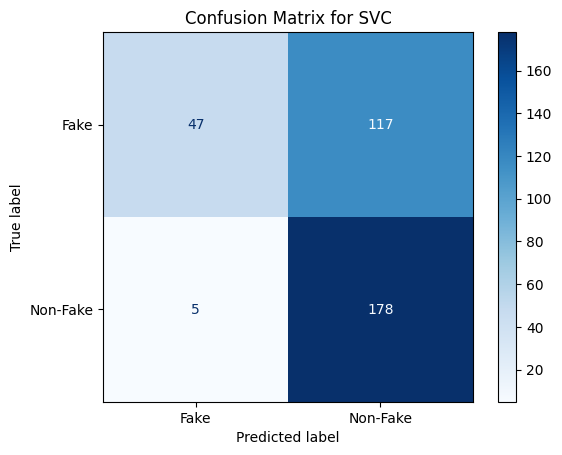

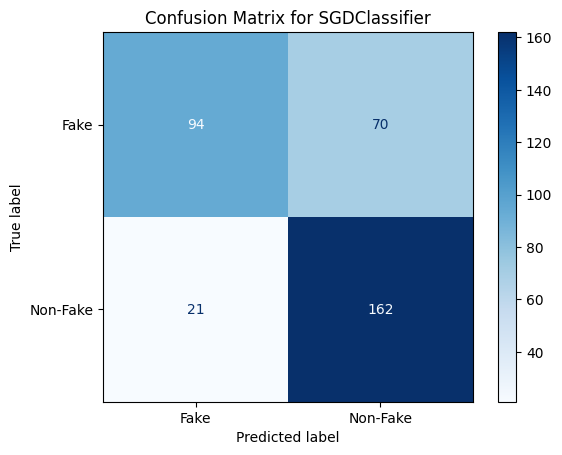

Evaluating Models for Trigram TF-IDF...


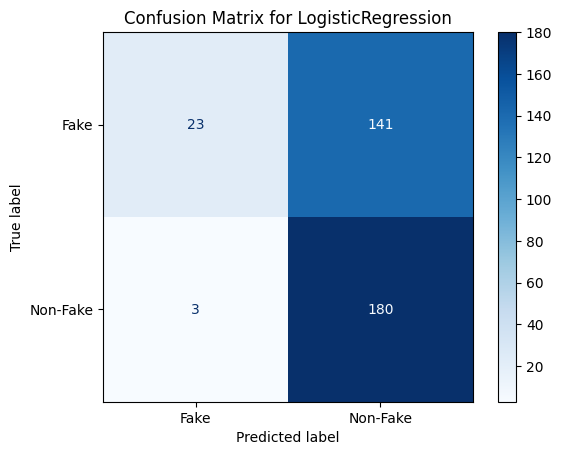

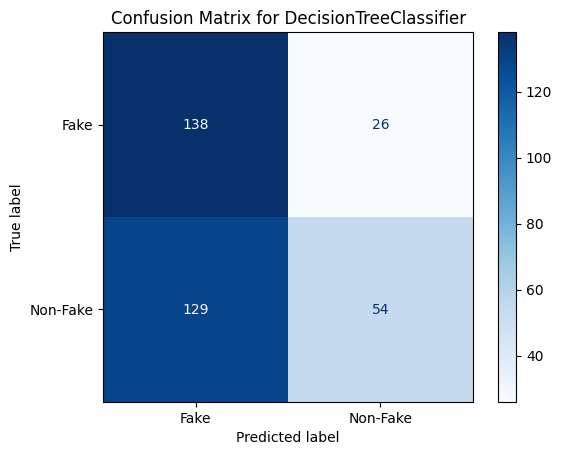

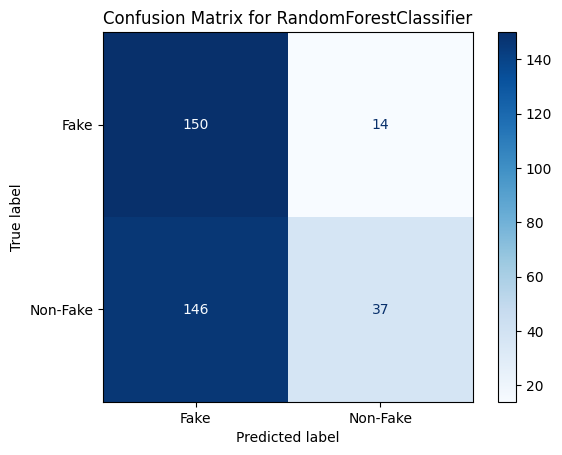

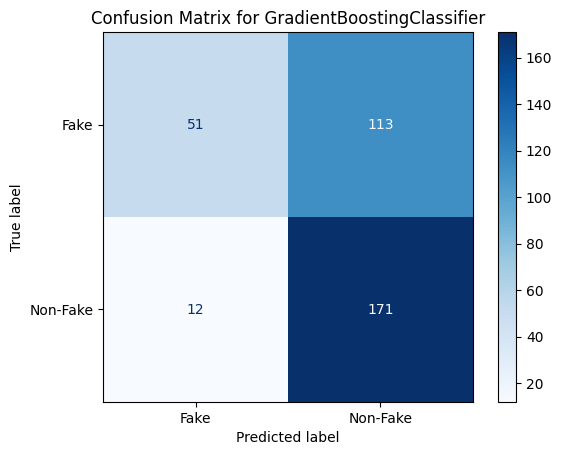

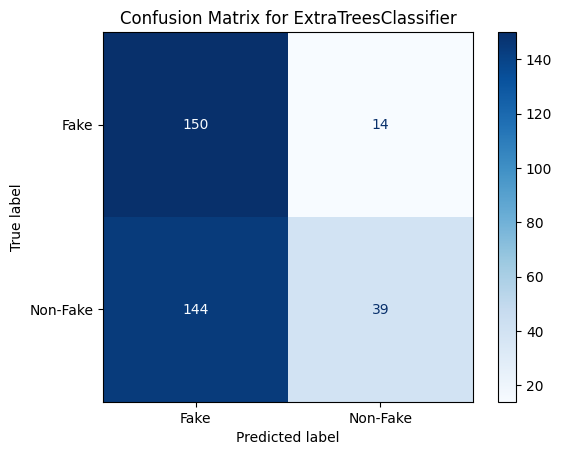

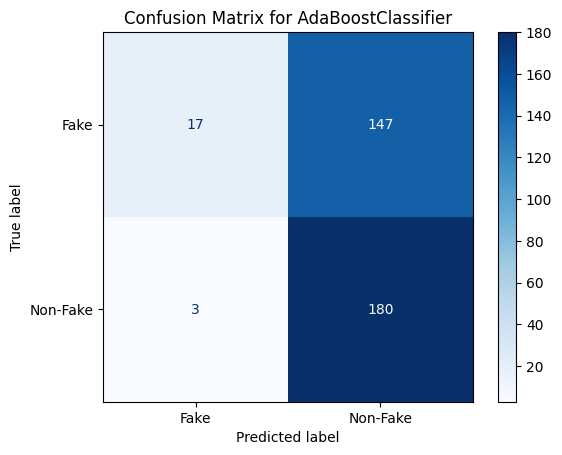

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:57:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


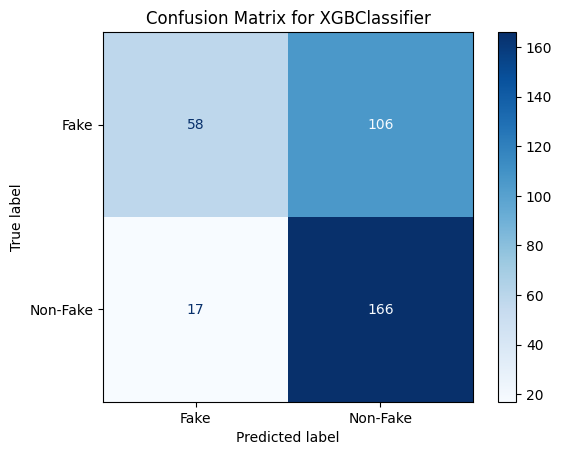

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


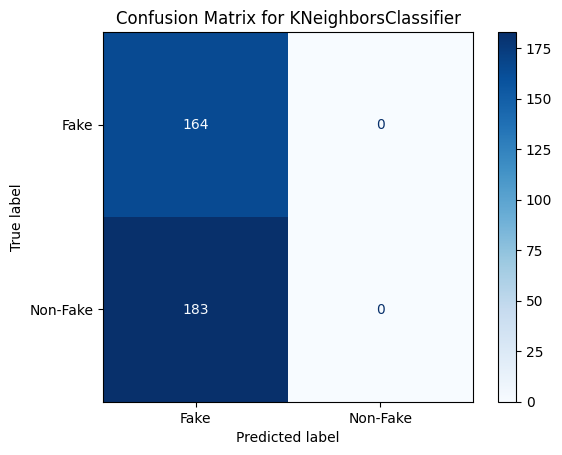

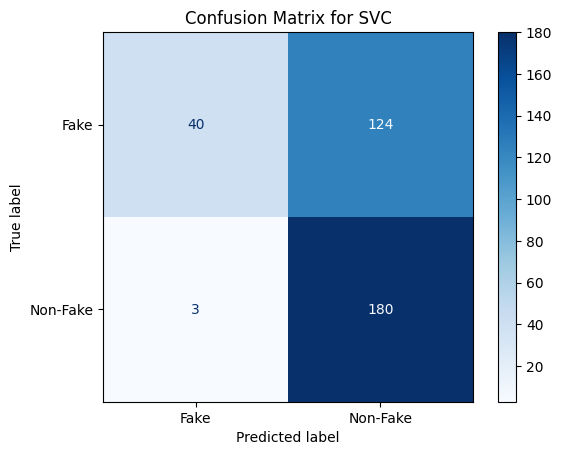

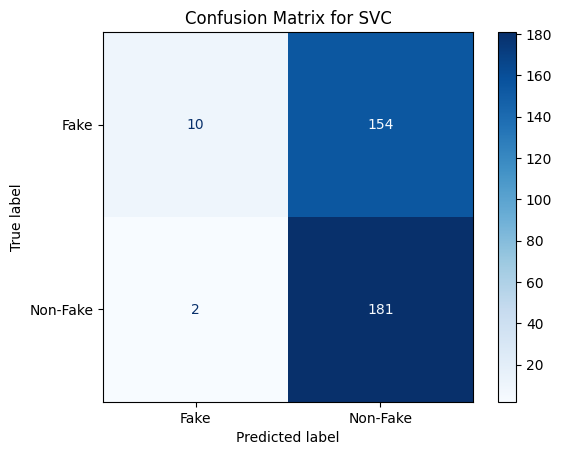

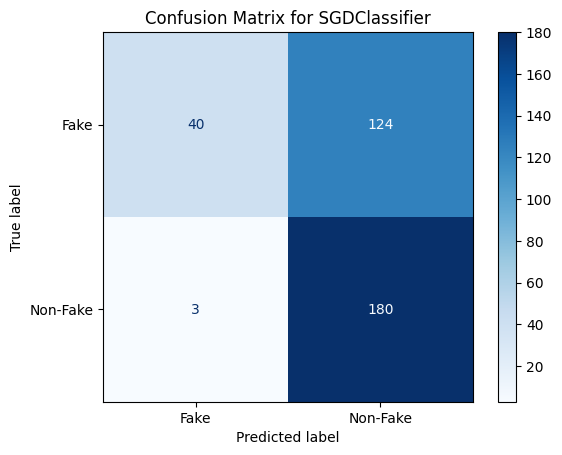

Unigram Performance:
                    Accuracy  Precision    Recall  F1 Score
LogisticRegression  0.752161   0.727700  0.846995  0.782828
DecisionTree        0.590778   0.624242  0.562842  0.591954
RandomForest        0.726225   0.707547  0.819672  0.759494
GradientBoosting    0.752161   0.734300  0.830601  0.779487
ExtraTrees          0.746398   0.718894  0.852459  0.780000
AdaBoost            0.694524   0.699482  0.737705  0.718085
XGBoost             0.720461   0.721649  0.765027  0.742706
KNN                 0.688761   0.684729  0.759563  0.720207
LinearSVM           0.757925   0.748744  0.814208  0.780105
RBF_SVM             0.769452   0.733032  0.885246  0.801980
SGD                 0.752161   0.759358  0.775956  0.767568
Bigram Performance:
                    Accuracy  Precision    Recall  F1 Score
LogisticRegression  0.711816   0.653137  0.967213  0.779736
DecisionTree        0.645533   0.645631  0.726776  0.683805
RandomForest        0.714697   0.672131  0.896175  0.768150

In [49]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import joblib


def calc_ngram_tfidf(text_data, ngram_range):
    vectorizer = TfidfVectorizer(ngram_range=ngram_range)
    feature_vector = vectorizer.fit_transform(text_data)
    return vectorizer, feature_vector

def label_encoding(labels):
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)
    return encoded_labels

def dataset_split(feature_space, sentiment, test_size=0.2, random_state=42):
    return train_test_split(feature_space, sentiment, test_size=test_size, random_state=random_state)

def ml_models_for_unigram_tfidf():
    ml_models = [
        LogisticRegression(max_iter=400),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        GradientBoostingClassifier(),
        ExtraTreesClassifier(),
        AdaBoostClassifier(),
        XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        KNeighborsClassifier(),
        SVC(kernel='linear'),
        SVC(kernel='rbf'),
        SGDClassifier()
    ]

    model_names = [
      'LogisticRegression',
      'DecisionTree',
      'RandomForest',
      'GradientBoosting',
      'ExtraTrees',
      'AdaBoost',
      'XGBoost',
      'KNN',
      'LinearSVM',
      'RBF_SVM',
      'SGD'
    ]

    return ml_models, model_names

def model_performance_with_confusion_matrix(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    cm = confusion_matrix(y_test, y_pred)

    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Non-Fake"])
    cm_display.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {model.__class__.__name__}')
    plt.show()

    return accuracy, precision, recall, f1, cm

def evaluate_models_for_ngram(X_train, X_test, y_train, y_test, ngram_type="Unigram"):
    print(f"Evaluating Models for {ngram_type} TF-IDF...")
    ml_models, model_names = ml_models_for_unigram_tfidf()
    performance = {}

    for i, model in enumerate(ml_models):
        accuracy, precision, recall, f1, cm = model_performance_with_confusion_matrix(model, X_train, X_test, y_train, y_test)
        performance[model_names[i]] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1
        }

    performance_df = pd.DataFrame(performance).T
    return performance_df

def main(df):
    cv_uni, feature_vector_uni = calc_ngram_tfidf(df['review'], ngram_range=(1, 1))
    labels_uni = label_encoding(df['label'])
    X_train_uni, X_test_uni, y_train_uni, y_test_uni = dataset_split(feature_space=feature_vector_uni, sentiment=labels_uni)

    cv_bi, feature_vector_bi = calc_ngram_tfidf(df['review'], ngram_range=(2, 2))
    labels_bi = label_encoding(df['label'])
    X_train_bi, X_test_bi, y_train_bi, y_test_bi = dataset_split(feature_space=feature_vector_bi, sentiment=labels_bi)

    cv_tri, feature_vector_tri = calc_ngram_tfidf(df['review'], ngram_range=(3, 3))
    labels_tri = label_encoding(df['label'])
    X_train_tri, X_test_tri, y_train_tri, y_test_tri = dataset_split(feature_space=feature_vector_tri, sentiment=labels_tri)


    performance_uni = evaluate_models_for_ngram(X_train_uni, X_test_uni, y_train_uni, y_test_uni, ngram_type="Unigram")
    performance_bi = evaluate_models_for_ngram(X_train_bi, X_test_bi, y_train_bi, y_test_bi, ngram_type="Bigram")
    performance_tri = evaluate_models_for_ngram(X_train_tri, X_test_tri, y_train_tri, y_test_tri, ngram_type="Trigram")

    print("Unigram Performance:")
    print(performance_uni)
    print("Bigram Performance:")
    print(performance_bi)
    print("Trigram Performance:")
    print(performance_tri)


    if performance_uni['Accuracy'].max() > performance_bi['Accuracy'].max() and performance_uni['Accuracy'].max() > performance_tri['Accuracy'].max():
        best_performance = performance_uni
        best_ngram_type = "Unigram"
        best_vectorizer = cv_uni
        X_train_best = X_train_uni
        y_train_best = y_train_uni
    elif performance_bi['Accuracy'].max() > performance_uni['Accuracy'].max() and performance_bi['Accuracy'].max() > performance_tri['Accuracy'].max():
        best_performance = performance_bi
        best_ngram_type = "Bigram"
        best_vectorizer = cv_bi
        X_train_best = X_train_bi
        y_train_best = y_train_bi
    else:
        best_performance = performance_tri
        best_ngram_type = "Trigram"
        best_vectorizer = cv_tri
        X_train_best = X_train_tri
        y_train_best = y_train_tri


    best_model_name = best_performance['Accuracy'].idxmax()


    ml_models, model_names = ml_models_for_unigram_tfidf()
    best_model_index = model_names.index(best_model_name)
    best_model = ml_models[best_model_index]
    best_model.fit(X_train_best, y_train_best)


    joblib.dump(best_model, "best_model.pkl")
    joblib.dump(best_vectorizer, "best_vectorizer.pkl")

    print(f"Best Model ({best_model_name}) saved as 'best_model.pkl'.")
    print(f"Best {best_ngram_type} Vectorizer saved as 'best_vectorizer.pkl'.")
    print(f"Model is fitted: {hasattr(best_model, 'coef_') or hasattr(best_model, 'feature_importances_')}")

    return best_model, best_vectorizer


best_model, best_vectorizer = main(df)



In [50]:
text="অনেকদিন কেউ কোনকিছু ধরতে দেয় নাহ অবশেষে মুরগিই আমাকে সুযোগটা দিল তাও মাত্র ১২২ টাকায় এই ধরার সুযোগটা আমাকে করে দিল পান্থপথে অবস্থিত আদি অষ্টব্যঞ্জন রেস্টুরেন্ট"
# Prediction example
def predict_new_text(text, model_path="best_model.pkl", vectorizer_path="best_vectorizer.pkl"):
    # Load model and vectorizer
    loaded_model = joblib.load(model_path)
    loaded_vectorizer = joblib.load(vectorizer_path)

    # Vectorize new text
    new_text_vectorized = loaded_vectorizer.transform([text])

    # Predict
    prediction = loaded_model.predict(new_text_vectorized)
    return prediction
predict_new_text(text)

array([0])

In [53]:
import joblib

# Load the model
model = joblib.load("best_model.pkl")


# Main code for deployment using pickle and using unigram to get the best model

In [54]:
import joblib
import pickle

def verify_pickle_file(file_path):
    try:
        joblib.load(file_path)
        print(f"Joblib: {file_path} is valid.")
    except Exception as e:
        print(f"Joblib load failed: {e}")

    try:
        with open(file_path, 'rb') as f:
            pickle.load(f)
        print(f"Pickle: {file_path} is valid.")
    except Exception as e:
        print(f"Pickle load failed: {e}")

verify_pickle_file("best_model.pkl")

Joblib: best_model.pkl is valid.
Pickle load failed: invalid load key, '\x05'.


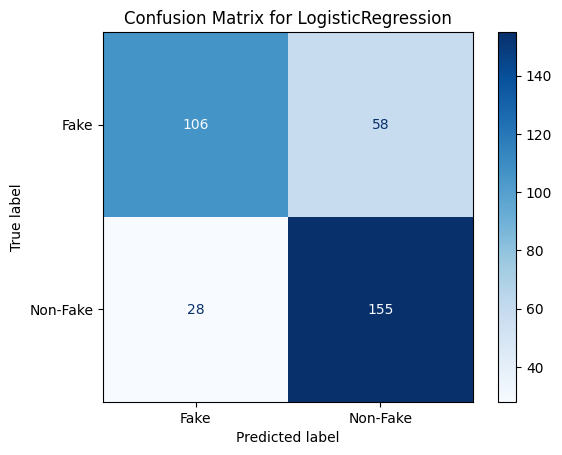

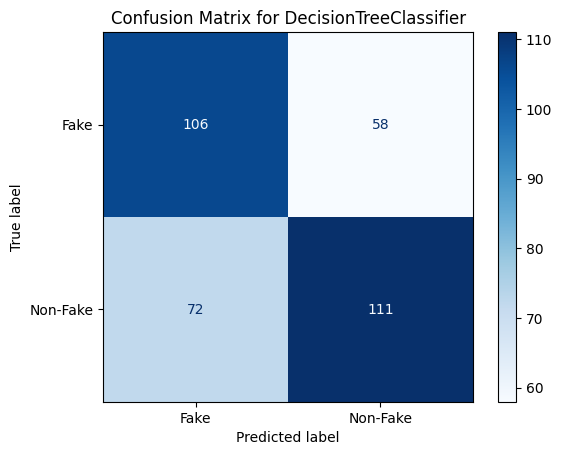

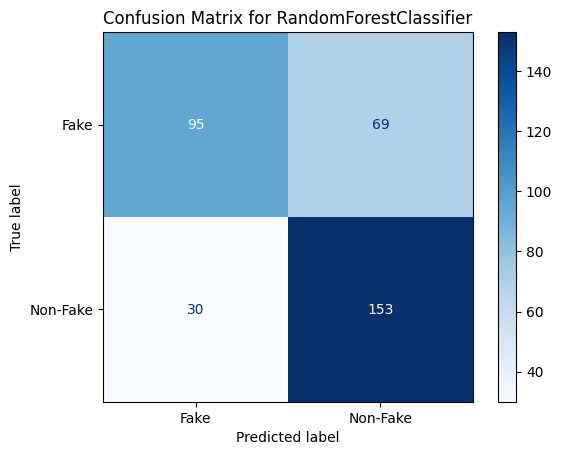

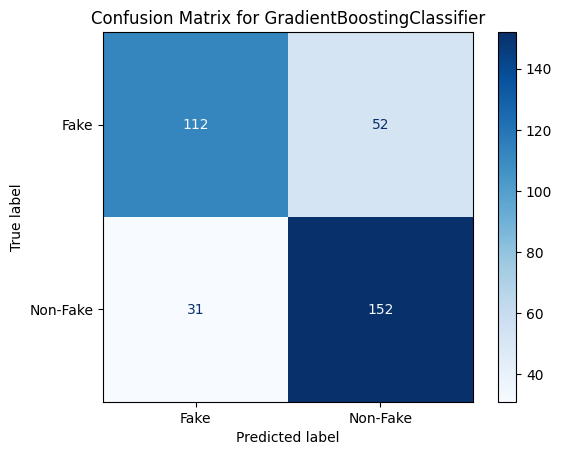

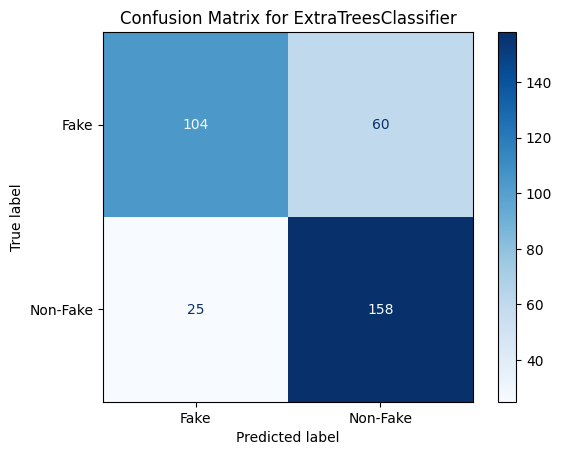

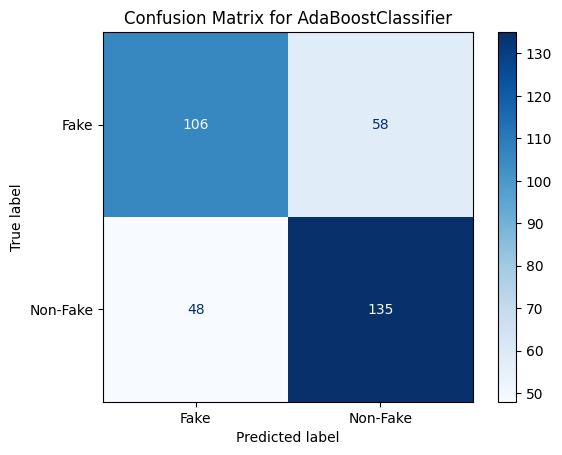

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:55:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


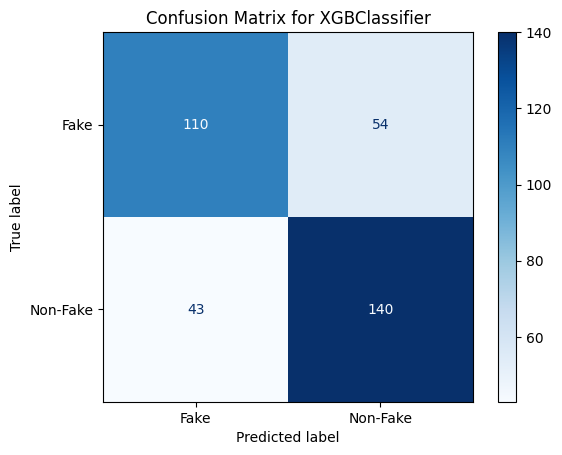

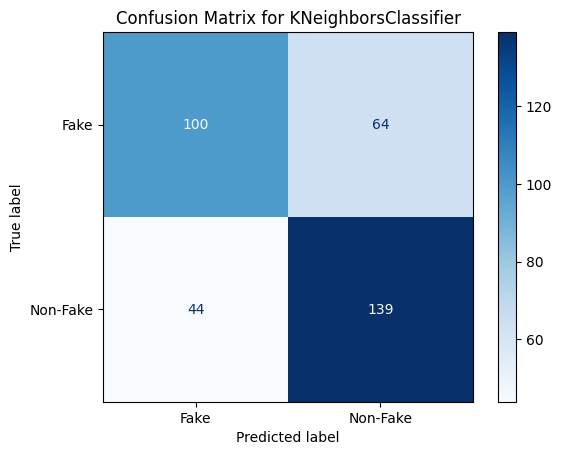

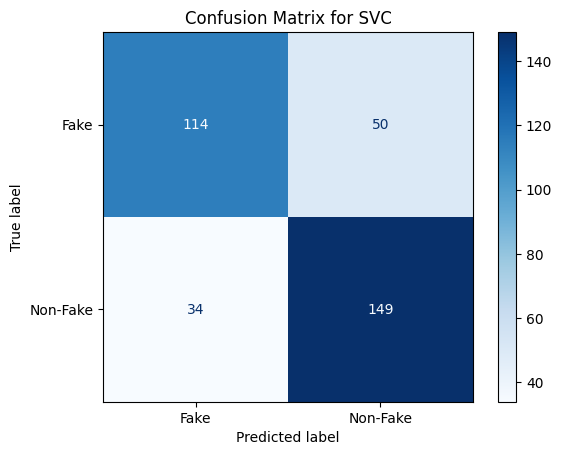

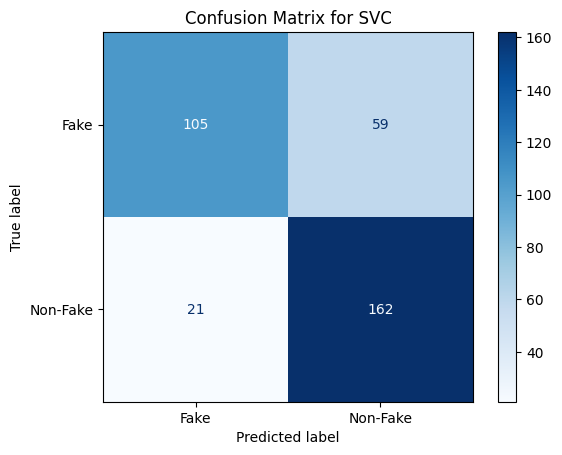

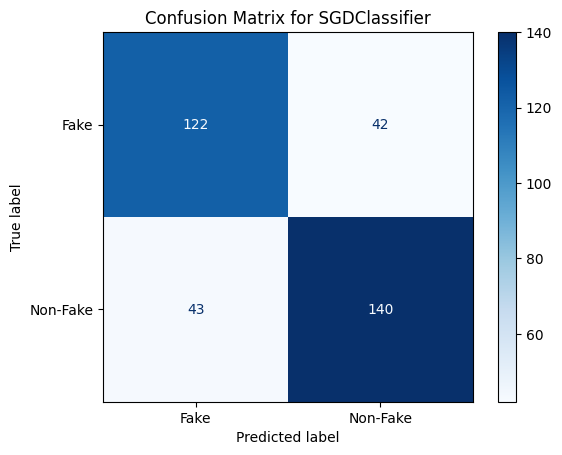

Unigram Performance:
                    Accuracy  Precision    Recall  F1 Score
LogisticRegression  0.752161   0.727700  0.846995  0.782828
DecisionTree        0.625360   0.656805  0.606557  0.630682
RandomForest        0.714697   0.689189  0.836066  0.755556
GradientBoosting    0.760807   0.745098  0.830601  0.785530
ExtraTrees          0.755043   0.724771  0.863388  0.788030
AdaBoost            0.694524   0.699482  0.737705  0.718085
XGBoost             0.720461   0.721649  0.765027  0.742706
KNN                 0.688761   0.684729  0.759563  0.720207
LinearSVM           0.757925   0.748744  0.814208  0.780105
RBF_SVM             0.769452   0.733032  0.885246  0.801980
SGD                 0.755043   0.769231  0.765027  0.767123
Models saved successfully
Best Model (RBF_SVM) saved.
Best Unigram Vectorizer saved.
Prediction for 'Amazing product, very happy with my purchase': Positive


In [57]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle

def calc_ngram_tfidf(text_data, ngram_range):
    vectorizer = TfidfVectorizer(ngram_range=ngram_range)
    feature_vector = vectorizer.fit_transform(text_data)
    return vectorizer, feature_vector

def label_encoding(labels):
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)
    return encoded_labels

def dataset_split(feature_space, sentiment, test_size=0.2, random_state=42):
    return train_test_split(feature_space, sentiment, test_size=test_size, random_state=random_state)

def model_performance_with_confusion_matrix(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    cm = confusion_matrix(y_test, y_pred)

    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Non-Fake"])
    cm_display.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {model.__class__.__name__}')
    plt.show()

    return accuracy, precision, recall, f1, cm
def ml_models_for_unigram_tfidf():
    ml_models = [
        LogisticRegression(max_iter=400),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        GradientBoostingClassifier(),
        ExtraTreesClassifier(),
        AdaBoostClassifier(),
        XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        KNeighborsClassifier(),
        SVC(kernel='linear'),
        SVC(kernel='rbf'),
        SGDClassifier()
    ]

    model_names = [
      'LogisticRegression',
      'DecisionTree',
      'RandomForest',
      'GradientBoosting',
      'ExtraTrees',
      'AdaBoost',
      'XGBoost',
      'KNN',
      'LinearSVM',
      'RBF_SVM',
      'SGD'
    ]

    return ml_models, model_names

def evaluate_model_for_unigram(X_train, X_test, y_train, y_test):
    #ml_models = [LogisticRegression(max_iter=400)]
    #model_names = ['LogisticRegression']
    ml_models, model_names = ml_models_for_unigram_tfidf()

    performance = {}
    performance = {}

    for i, model in enumerate(ml_models):
        accuracy, precision, recall, f1, cm = model_performance_with_confusion_matrix(model, X_train, X_test, y_train, y_test)
        performance[model_names[i]] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1
        }

    performance_df = pd.DataFrame(performance).T
    return performance_df

def save_model_safely(model, vectorizer):
    try:
        with open("/content/best_model_hoi.pkl", 'wb') as model_file:
            pickle.dump(model, model_file)

        with open("/content/best_vectorizer_hoi.pkl", 'wb') as vectorizer_file:
            pickle.dump(vectorizer, vectorizer_file)

        print("Models saved successfully")
    except Exception as e:
        print(f"Error saving models: {e}")

def load_model_safely():
    try:
        with open("/content/best_model_hoi.pkl", 'rb') as model_file:
            model = pickle.load(model_file)

        with open("/content/best_vectorizer_hoi.pkl", 'rb') as vectorizer_file:
            vectorizer = pickle.load(vectorizer_file)

        return model, vectorizer
    except Exception as e:
        print(f"Failed to load model: {e}")
        return None, None

def predict_text(text, model, vectorizer):
    text_vectorized = vectorizer.transform([text])
    prediction = model.predict(text_vectorized)
    return prediction[0]

def main(df):
    # Unigram TF-IDF
    cv_uni, feature_vector_uni = calc_ngram_tfidf(df['review'], ngram_range=(1, 1))
    labels_uni = label_encoding(df['label'])
    X_train_uni, X_test_uni, y_train_uni, y_test_uni = dataset_split(feature_space=feature_vector_uni, sentiment=labels_uni)

    # Model Evaluation for Unigram
    performance_uni = evaluate_model_for_unigram(X_train_uni, X_test_uni, y_train_uni, y_test_uni)

    print("Unigram Performance:")
    print(performance_uni)

    # Best Model based on accuracy
    best_model_name = performance_uni['Accuracy'].idxmax()
    best_model = LogisticRegression(max_iter=400)
    best_model.fit(X_train_uni, y_train_uni)

    # Save models
    save_model_safely(best_model, cv_uni)

    print(f"Best Model ({best_model_name}) saved.")
    print(f"Best Unigram Vectorizer saved.")

    return best_model, cv_uni


# Train and save model
best_model, best_vectorizer = main(df)

# Predict new text
new_text = "Amazing product, very happy with my purchase"
prediction = predict_text(new_text, best_model, best_vectorizer)
print(f"Prediction for '{new_text}': {'Positive' if prediction == 1 else 'Negative'}")


**Validating the pickle file**

In [58]:
import joblib
import pickle

def verify_pickle_file(file_path):
    try:
        joblib.load(file_path)
        print(f"Joblib: {file_path} is valid.")
    except Exception as e:
        print(f"Joblib load failed: {e}")

    try:
        with open(file_path, 'rb') as f:
            pickle.load(f)
        print(f"Pickle: {file_path} is valid.")
    except Exception as e:
        print(f"Pickle load failed: {e}")

# Usage
verify_pickle_file("best_model_hoi.pkl")

Joblib: best_model_hoi.pkl is valid.
Pickle: best_model_hoi.pkl is valid.


avoid it!!!
word2vec code

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


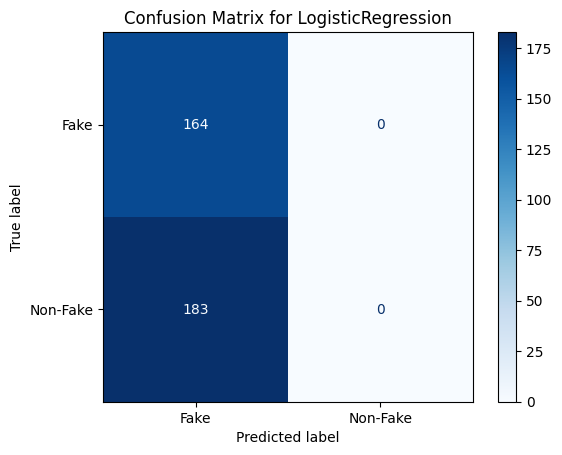

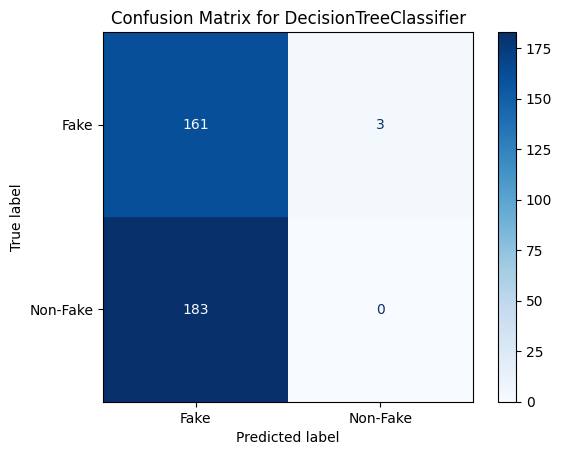

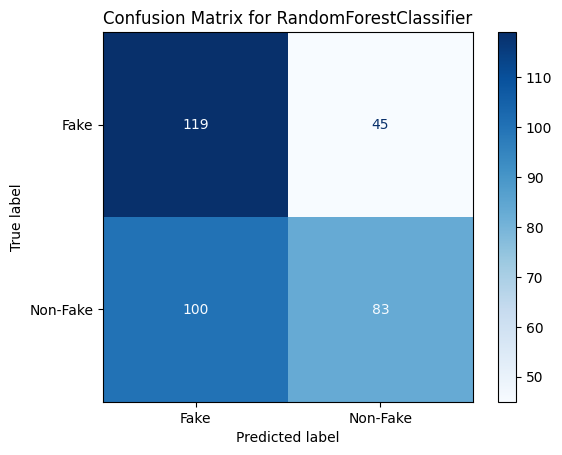

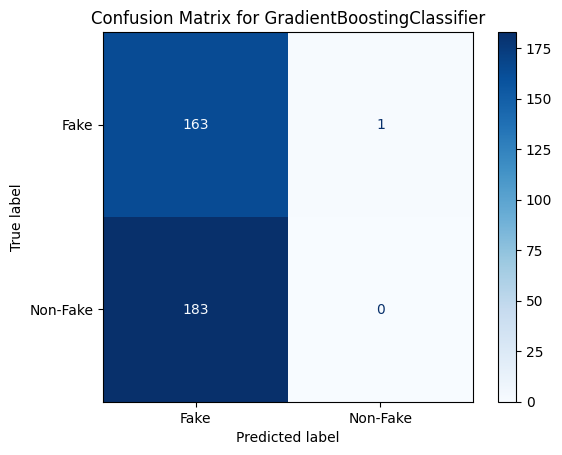

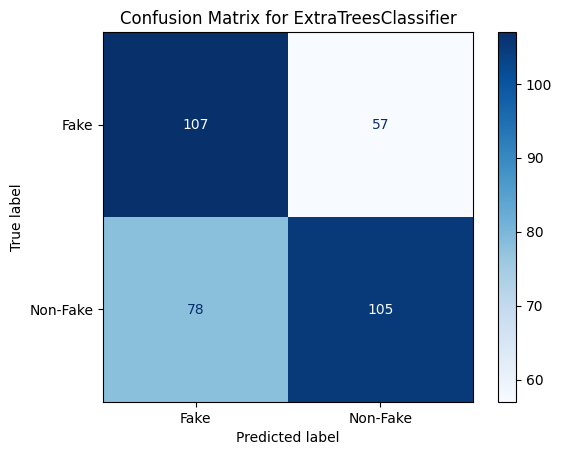

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


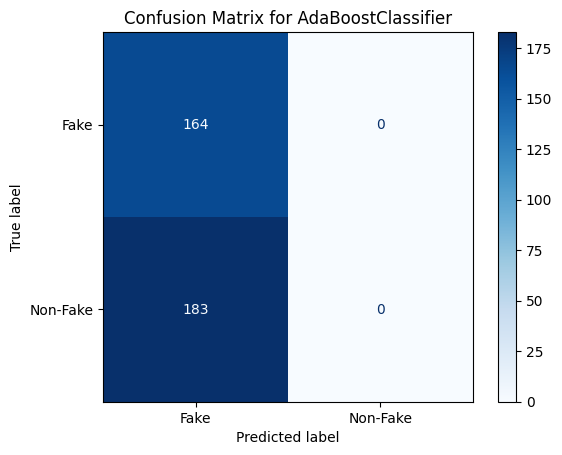

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:18:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


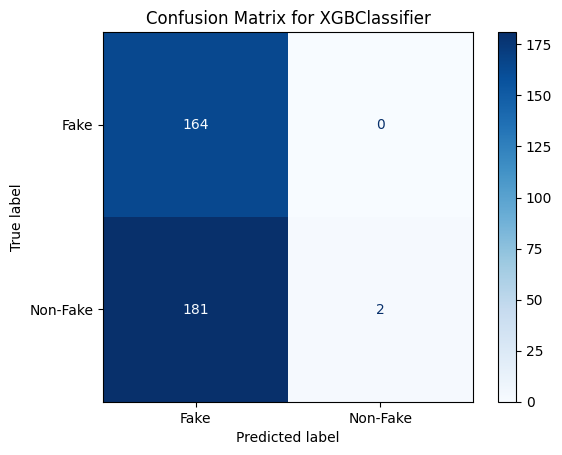

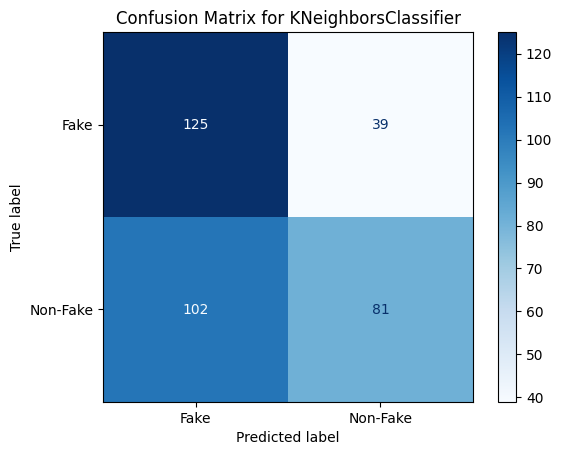

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


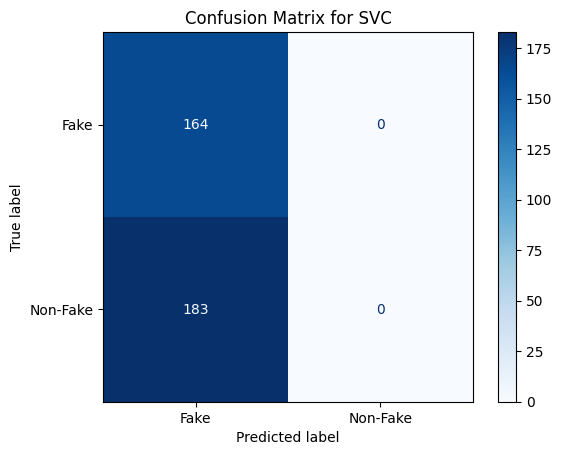

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


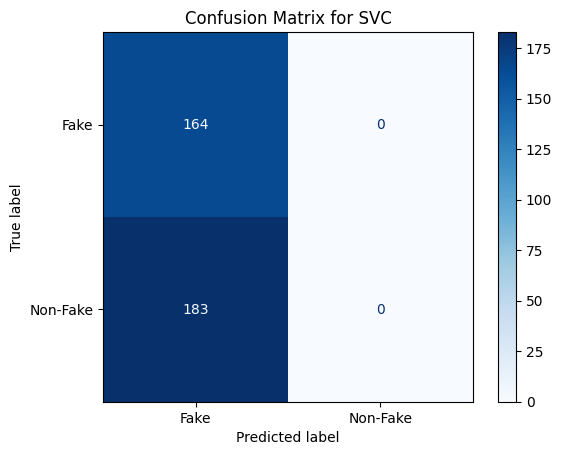

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


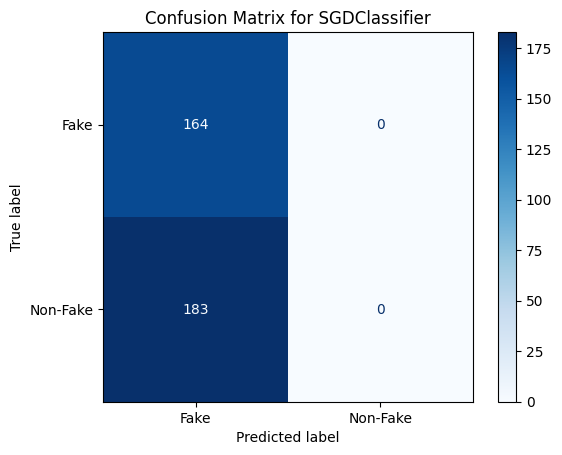

                    Accuracy  Precision    Recall  F1 Score
LogisticRegression  0.472622   0.000000  0.000000  0.000000
DecisionTree        0.463977   0.000000  0.000000  0.000000
RandomForest        0.582133   0.648438  0.453552  0.533762
GradientBoosting    0.469741   0.000000  0.000000  0.000000
ExtraTrees          0.610951   0.648148  0.573770  0.608696
AdaBoost            0.472622   0.000000  0.000000  0.000000
XGBoost             0.478386   1.000000  0.010929  0.021622
KNN                 0.593660   0.675000  0.442623  0.534653
LinearSVM           0.472622   0.000000  0.000000  0.000000
RBF_SVM             0.472622   0.000000  0.000000  0.000000
SGD                 0.472622   0.000000  0.000000  0.000000


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier  # XGBoost
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import numpy as np

# Define ML models (excluding MultinomialNB for Word2Vec)
def ml_models():
    models = [
        LogisticRegression(max_iter=1000),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        GradientBoostingClassifier(),
        ExtraTreesClassifier(),
        AdaBoostClassifier(),
        XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        KNeighborsClassifier(),
        SVC(kernel='linear'),
        SVC(kernel='rbf'),
        SGDClassifier()
    ]

    model_names = [
        'LogisticRegression',
        'DecisionTree',
        'RandomForest',
        'GradientBoosting',
        'ExtraTrees',
        'AdaBoost',
        'XGBoost',
        'KNN',
        'LinearSVM',
        'RBF_SVM',
        'SGD'
    ]

    return models, model_names

# Train and evaluate models with confusion matrix
def model_performance_with_cm(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Non-Fake"])
    cm_display.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {model.__class__.__name__}')
    plt.show()

    return accuracy, precision, recall, f1

# Evaluate multiple models
def evaluate_models(X_train, X_test, y_train, y_test):
    models, model_names = ml_models()
    performance = {}

    for i, model in enumerate(models):
        accuracy, precision, recall, f1 = model_performance_with_cm(model, X_train, X_test, y_train, y_test)
        performance[model_names[i]] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1
        }

    return pd.DataFrame(performance).T

# **Word2Vec Feature Extraction**
def word2vec_features(df):
    sentences = [text.split() for text in df]
    word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

    # Convert words to vector representation
    def avg_word_vectors(text):
        words = text.split()
        vectors = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
        return np.mean(vectors, axis=0) if vectors else np.zeros(100)

    X_word2vec = np.array([avg_word_vectors(text) for text in df])

    # Apply ReLU to avoid negative values
    X_word2vec = np.maximum(X_word2vec, 0)
    return X_word2vec

# **Choose Feature Type (Word2Vec)**
def feature_extraction(df, method='word2vec'):
    if method == 'word2vec':
        return word2vec_features(df)

# **Example Usage**
# Assuming df, y_train, y_test are defined
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['label'], test_size=0.2, random_state=42)

# Extract Word2Vec features for train and test separately
X_train_features = feature_extraction(X_train, method='word2vec')
X_test_features = feature_extraction(X_test, method='word2vec')

# Now, evaluate the models with the extracted Word2Vec features
performance_df = evaluate_models(X_train_features, X_test_features, y_train, y_test)
print(performance_df)


In [ ]:
import joblib

# Load the model and vectorizer
best_model = joblib.load("best_model.pkl")
best_vectorizer = joblib.load("best_vectorizer.pkl")


In [ ]:
print(f"Is model fitted? {hasattr(best_model, 'feature_importances_')}")


Is model fitted? False


In [ ]:
# Example input (replace with your own text)
new_text = ["valo khabar"]

# Convert the text to feature vectors using the saved vectorizer
new_text_vectorized = best_vectorizer.transform(new_text)

# Predict using the saved model
prediction = best_model.predict(new_text_vectorized)

# Display prediction
print(f"Predicted Class: {prediction[0]}")


NotFittedError: This ExtraTreesClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.